In [1]:
import numpy as np
import pandas as pd
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt

# Reading and Preprocessing Data

In [2]:
def read_excel(data):
    df = pd.read_excel('Data Prep.xlsx', index_col=0, sheet_name=data)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df

def read_excel_revisi(data):
    df = pd.read_excel('Data Prep Revisi.xlsx', index_col=0, sheet_name=data)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df



def mirroring(df): 
    df_c = df.copy()
    df = df.fillna(0)
    df = df + df.T
    df[df_c.isnull() & (df == 0)] = None
    return df

def set_same_zero(df):
    df_column = df.columns.values
    df_column = set(df_column)
    df_index = df.index.values
    df_index = set(df_index)
    same_port = df_index & df_column

    # making same port data into 0 
    for i in same_port:
        df[i][i]=0
    return df


In [3]:
alpha_up = read_excel('alpha_up')

GAMMA_TL = read_excel('GAMMA_TL')

w = read_excel('w')
w = mirroring(w)
w = set_same_zero(w)

TL_char = read_excel_revisi('TL_char')
PL_char = read_excel_revisi('PL_char')
PR_char = read_excel_revisi('PR_char')

beta_up = read_excel('beta_up')

gamma_uu = read_excel('gamma_uu')
gamma_uu = mirroring(gamma_uu)
gamma_uu = set_same_zero(gamma_uu)


SIGMA_PL = read_excel('SIGMA_PL')



sigma_pr = read_excel('sigma_pr')

PSI_PR = read_excel('PSI_PR')

z_pr = read_excel('z_pr')

special_PR = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='special_PR')
special_PR = special_PR.applymap(lambda x: x.strip() if isinstance(x, str) else x)

port_item = pd.read_excel('data.xlsx',index_col=0 , sheet_name='Barang')
port_item = port_item.applymap(lambda x: x.strip() if isinstance(x, str) else x)

biaya_jarak_teus = read_excel_revisi('Biaya_Jarak_Teus')

wave_status = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='wave_status')
wave_status = wave_status.applymap(lambda x: x.strip() if isinstance(x, str) else x)

ports = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='ports')
ports = ports.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [4]:
R_list = ports[ports['port_type'] == 'R']['port'].to_list()
P_list = ports[ports['port_type'] == 'P']['port'].to_list()
PL_P_list = ['Banda Neira','Dobo','Ambon','Tual','Saumlaki']
PL_non_P_list = list(set(P_list)-set(PL_P_list))

In [5]:
special_P_port = special_PR.columns.to_list()
wave_status['PR_availability'] = wave_status['wave_h']<2

In [6]:
Ambon_R_list = special_PR['Ambon'].dropna().to_list()
Tual_R_list = special_PR['Tual'].dropna().to_list()
Saumlaki_R_list = special_PR['Saumlaki'].dropna().to_list()

In [7]:
TL1_data = pd.read_excel('Data Ship.xlsx', sheet_name='TL1')
TL2_data = pd.read_excel('Data Ship.xlsx', sheet_name='TL2')
PL1_data = pd.read_excel('Data Ship.xlsx', sheet_name='PL1')
PR_Ambon_data = pd.read_excel('Data Ship.xlsx', sheet_name='PR_Ambon')
PR_Saumlaki_data = pd.read_excel('Data Ship.xlsx', sheet_name='PR_Saumlaki')
PR_Tual_data = pd.read_excel('Data Ship.xlsx', sheet_name='PR_Tual')


#### Filling Data with Dummy Data

In [8]:
def fill_mean(df):
    df = df.fillna(df.mean().mean())
    return df

w = fill_mean(w)
SIGMA_PL = fill_mean(SIGMA_PL)
sigma_pr = fill_mean(sigma_pr)
z_pr = fill_mean(z_pr)
PSI_PR = fill_mean(PSI_PR)
PR_char = fill_mean(PR_char)
biaya_jarak_teus = fill_mean(biaya_jarak_teus)
TL_char = fill_mean(TL_char)
PL_char = fill_mean(PL_char)
PR_char = fill_mean(PR_char)

# Data Dummy

In [9]:
all_port_item  = pd.read_csv('barang_dummy.csv',index_col=0)
all_port_item = all_port_item.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [10]:
from_list = all_port_item['Pelabuhan'].to_list()
for i in range(len(all_port_item)):
    all_port_item['Tujuan Pelabuhan'].iloc[0] = random.choice(from_list)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


# Creating Objects and Function

In [11]:
def quickport(port_name):
    name = ports[ports['port'] == port_name]['port'].values[0]
    port_type = ports[ports['port'] == port_name]['port_type'].values[0]
    return Port(name,port_type)

In [12]:
def chooseport(port_name):
    port_name = port_name.rstrip()
    port_name = port_name.lstrip()
    return ports[ports['port'] == port_name]['port_object'].iloc[0]

In [13]:
def add_TL_route(route):
    finished = False
    i = 0
    while finished == False:
        current_item = route[i]
        if current_item.name in ['Ambon','Saumlaki','Tual']:
            k=0
            for j in movable_TL[current_item.name]:
                k+=1
                route.insert(i+k,j)
            i+=len(movable_TL[current_item.name])
        i+=1
        if len(route) <= i:
            break
    return route

In [14]:
def port_items(port):
    global all_port_item
    item_list = all_port_item[all_port_item['Pelabuhan'] == port]
    return item_list

In [15]:
def find_distance(port_a,port_b):
    distance = 10+(np.random.rand()*20) #TODO: FIND DISTANCE
    return distance

In [16]:
def choose_char(ship_type):
    global TL_char, PL_char, PR_char
    if ship_type=='TL':
        ship_char = TL_char
    elif ship_type=='PL':
        ship_char = PL_char
    elif ship_type=='PR':
        ship_char = PR_char
    return ship_char

In [17]:
def per_item_revenue(data):
#     distance = find_distance(data['Pelabuhan'],data['Tujuan Pelabuhan'])
    distance = data['Jarak']
    Bobot = data['Bobot']
    BJT = biaya_jarak_teus[data['Pelabuhan']][data['Tujuan Pelabuhan']]
    income = distance*Bobot*BJT
    return income

In [18]:
def port_revenue(storage_df):
    total_income = 0
    global gl, gli
    gl = storage_df
    for i in storage_df.index:
        gli = i
        income = per_item_revenue(storage_df.loc[i])
        total_income += income
    return total_income

In [19]:
def item_left(df):
    return int(df['Bobot'].sum())

In [20]:
def find_movable_port(ship_type,port_name):
    if ship_type == 'TL':
        flag = False
    elif ship_type == 'PR':
        flag = True
    else:
        added_route = []
        return added_route
    r_list = special_PR[port_name].dropna().to_list()
    route_list = wave_status[wave_status['Port'].isin(r_list)][wave_status['PR_availability'] == flag]['Port'].to_list()
    added_route = []
    for i in route_list:
        added_route.append(chooseport(i))
    return added_route

In [21]:
def all_item(available_ship):
    itemdf = pd.DataFrame(columns = ['Pelabuhan','Bobot','Tujuan Pelabuhan'])
    itemdf.index.name = 'code barang'
    for i in ports['port_object']:
        itemdf = itemdf.append(i.demand)
    for i in available_ship:
        itemdf = itemdf.append(i.storage)
    return itemdf

In [22]:
def create_route(route_list):
    route = []
    for i in route_list:
        route.append(chooseport(i))
    return route
    

In [23]:
def total_revenue(available_ship):
    total_revenue = 0
    for i in available_ship:
        total_revenue += i.revenue
    return total_revenue

In [24]:
def get_route(df):
    return df['Route'].to_list()

In [25]:
class Port:
    def __init__(self, name,port_type):
        self.name = name
        self.port_type = port_type
        self.demand = port_items(name)
        
    
    def __repr__(self):
        if self.port_type == 'U':
            port_type_name = 'Utama'
        elif self.port_type == 'P':
            port_type_name = 'Pengumpul'
        elif self.port_type == 'R':
            port_type_name = 'Pengumpan'
        else:
            port_type_name = 'NOT DEFINED'

        return port_type_name + ":" + self.name
    

In [26]:
class Ship:
    def __init__(self, ship_type, route=[], name='No Name'):
        self.name = name
        self.ship_type = ship_type
        self.revenue = 0
        self.route = route
        self.current_port = route[0]
        self.port_cycle = route
        self.route_list = []
        self.ship_char = choose_char(self.ship_type)
        self.destination_dist = 0
        self.current_dist = 1000
        self.speed = self.ship_char['ship_char']['V']
        for i in route:
            self.route_list.append(i.name)

        storage_df = pd.DataFrame(columns = ['Pelabuhan','Bobot','Tujuan Pelabuhan'])
        storage_df.index.name = 'code barang'
        self.storage = storage_df
        self.storage_volume = storage_df['Bobot'].sum()
        
        #Capacity
        self.capacity = self.ship_char['ship_char']['VC']
        
        
        #special route for TL depending on wave height
        if self.ship_type == 'TL':
            self.TL_Special_PR = list(set(route).intersection(set(special_PR.columns))) #TODO : CHECK PR NOT IN AND IN BASED ON WAVE
            portcycle_name =[]
            for i in self.port_cycle:
                portcycle_name.append(i.name)
            P_port_PR_transitport =  list(set(portcycle_name).intersection(set(special_PR.columns)))
            P_port_non_PR_transitport = [x for x in special_PR.columns if x not in P_port_PR_transitport]
            
            self.PR_transitport = []
            self.non_PR_transitport = []

            for i in P_port_PR_transitport:
                self.PR_transitport.extend(special_PR[i].dropna().to_list())
            for i in P_port_non_PR_transitport:
                self.non_PR_transitport.extend(special_PR[i].dropna().to_list())

    def update_storage_volume(self):
        self.storage_volume = self.storage['Bobot'].sum()

    def cycle_list(self):
        self.port_cycle = list(self.port_cycle[1:])+[self.port_cycle[0]]

    def find_destination(self):
        pick_item = False

        i = 0
        while pick_item == False:
            if i < len(self.port_cycle):
                pick_item = self.simulate_moving()
                if pick_item == False:
                    self.cycle_list()
            else:
                return
            i += 1
        self.cycle_list()
        self.destination = self.port_cycle[0]
        return self.destination
    
    def move_port(self):
        self.current_port = self.port_cycle[0]

    def cost_per_item(self,item ):
        Bobot = item['Bobot']
        bm_time = self.ship_char[self.current_port.name ]['bm_time']
        C_bm = self.ship_char[self.current_port.name ]['C_bm']
        inventory_cost = self.ship_char[self.current_port.name ]['inventory_cost']
        bm_time = self.ship_char[self.current_port.name ]['bm_time']
        avg_docking_time = self.ship_char[self.current_port.name ]['avg_docking_time']
#         distance = find_distance(item['Pelabuhan'],self.current_port.name )
        distance = item['Jarak']
        V = self.ship_char['ship_char']['V']
        VC = self.ship_char['ship_char']['VC']
        port_storage_time = self.ship_char[self.current_port.name ]['port_storage_time']
        C_storage = self.ship_char[self.current_port.name ]['C_storage']

        total_cost_bongkar = Bobot*bm_time*C_bm
        total_cost_storage = Bobot * port_storage_time * C_storage
        total_cost_travel_time = inventory_cost*bm_time*(avg_docking_time*(distance/V))
        cost_bongkar_time = inventory_cost * (Bobot/C_bm)

        travel_cost = total_cost_bongkar + total_cost_storage+total_cost_travel_time+cost_bongkar_time
        
#         print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&')        
#         print('item: '+str(item))
#         print('bm time:'+str(bm_time))
#         print('C_bm:'+str(C_bm))
#         print('inventory_cost:'+str(inventory_cost))
#         print('bm_time:'+str(bm_time))
#         print('avg_docking_time:'+str(avg_docking_time))
#         print('distance:'+str(distance))
#         print('V:'+str(V))
#         print('VC:'+str(VC))
#         print('port_storage_time:'+str(port_storage_time))
#         print('C_storage:'+str(C_storage))
#         print('bongkar: {} storage: {} travelT: {} btime: {}'.format(total_cost_bongkar,total_cost_storage,total_cost_travel_time,cost_bongkar_time))
#         print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&')
        
        return travel_cost, [total_cost_bongkar, total_cost_storage, total_cost_travel_time, cost_bongkar_time]
    
    def drop_off_item(self,tujuan_pelabuhan,finish_shipping = True):
        ship_item = self.storage[self.storage['Tujuan Pelabuhan'] == tujuan_pelabuhan]
        self.storage = pd.concat([self.storage, ship_item]).drop_duplicates(keep=False)
        
        if finish_shipping == False:
            ship_item['Pelabuhan'] = self.current_port.name
            self.current_port.demand = self.current_port.demand.append(ship_item)
        elif finish_shipping == True:
            self.revenue += port_revenue(ship_item)
        
        #CALCULATING SHIP COST        
        total_cost_bongkar = 0
        total_cost_storage = 0
        total_cost_travel_time = 0
        cost_bongkar_time = 0
        travel_cost = 0
        for i in list(ship_item.index):
            item = ship_item.loc[i]
            travel_cost,_ = self.cost_per_item(item)
        self.revenue -= travel_cost

        self.update_storage_volume()
            
        return ship_item
    
    def pick_up_each(self,port_item):
        for i in port_item.index:
            current_port_item = port_item.loc[i]
            bobot_item = current_port_item['Bobot']
            if (self.storage_volume + bobot_item)<=self.capacity:
                bobot_item_df = pd.DataFrame(current_port_item).T
                self.current_port.demand = pd.concat([self.current_port.demand, bobot_item_df]).drop_duplicates(keep=False)
                bobot_item_df['Jarak'] = 0
                self.storage = self.storage.append(bobot_item_df)
                self.update_storage_volume()    
    
    def pick_up_port(self,tujuan_pelabuhan):
        port_item = self.current_port.demand[self.current_port.demand['Tujuan Pelabuhan'] == tujuan_pelabuhan]
        self.pick_up_each(port_item)

    def check_item(self,tujuan_pelabuhan,pick_or_drop,pick_item=False):
        if pick_item == True:
            return pick_item
        else:
            if pick_or_drop == 'drop':
                ship_item = self.storage[self.storage['Tujuan Pelabuhan'] == tujuan_pelabuhan]
                pick_item = not(ship_item.empty)
            elif pick_or_drop == 'pick':
                port_item = self.port_cycle[1].demand[self.port_cycle[1].demand['Tujuan Pelabuhan'] == tujuan_pelabuhan]
                pick_item = not(port_item.empty)
            return pick_item
    
    def simulate_moving(self):
        # ITEM DROP OFF--------------------------------------------------------
        simulated_port = self.port_cycle[1]
        # ALL ITEM WITH PORT DESTINATION AT CURRENT PORT
        pick_item = False
        pick_item = self.check_item(simulated_port.name,'drop',pick_item=pick_item)

        #SPECIAL DROP OFF ITEM
        #FOR PR
        if self.ship_type == 'PR':
            if simulated_port.name not in R_list:
                for i in ports[~ports['port'].isin(self.route)]['port'].to_list():
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
        

        #for Tanjung Perak and Makassar
        if simulated_port.name in ['Tanjung Perak','Makassar']:            
            #FOR TL
            if self.ship_type == 'TL':
                pick_item = self.check_item('Tanjung Priok','drop',pick_item=pick_item)
                P_non_in_route = [x for x in ports[ports['port_type'] == 'P']['port'].to_list() if x not in self.route]
                U_non_in_route = [x for x in ports[ports['port_type'] == 'U']['port'].to_list() if x not in self.route]
                for i in self.non_PR_transitport:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
                for i in P_non_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
                for i in U_non_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
            #FOR PL
            elif self.ship_type == 'PL':
                not_in_route = [x for x in ports['port'].to_list() if x not in self.route]
                for i in not_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)

       #for Special PR (Ambon, Tual, and Saumlaki)
        if simulated_port.name in special_PR.columns:
            #FOR PL
            if self.ship_type == 'PL':
                current_port_R_ports = special_PR[simulated_port.name].dropna().to_list()                
                for i in current_port_R_ports:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
            #FOR TL
            elif self.ship_type == 'TL':
                current_r = find_movable_port('PR',simulated_port.name)
                for i in current_r:
                    pick_item = self.check_item(i.name,'drop',pick_item=pick_item)
        # ITEM DROP OFF--------------------------------------------------------

        
        
        
        # ITEM PICK UP--------------------------------------------------------
        
        #PICK UP IN PORT CYCLE
        for i in self.port_cycle:
            pick_item = self.check_item(i.name,'pick',pick_item=pick_item)

        #Take for Tanjung Priok
        if self.ship_type == 'TL':
            if self.current_port.name not in ['Tanjung Perak','Makassar']:
                self.check_item('Tanjung Priok','pick',pick_item=pick_item)
        if self.ship_type == 'PR':
            if self.current_port.name not in special_PR.columns:
                self.check_item('Tanjung Priok','pick',pick_item=pick_item)
            
        #SPECIAL FOR PL SHIP: 
        if self.ship_type == 'PL':
            #TAKE EVERYTHING with TANJUNG PRIOK
            self.pick_up_port('Tanjung Priok')
            if simulated_port.name not in special_PR.columns:
                for i in R_list:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)

            #TAKE EVERYTHING in BANDA NEIRA
            if self.current_port.name == 'Banda Neira':
                port_item = self.current_port.demand
                if pick_item == True:
                    pass
                else:
                    pick_item = not(port_item.empty)
                    
#         P not in special P
        if ((simulated_port.port_type == 'P') and (simulated_port.name not in special_PR.columns)):
            if self.ship_type == 'TL':
                for i in self.PR_transitport:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)


        #for Tanjung Priok
        if simulated_port.name == 'Tanjung Priok':
            if self.ship_type == 'PL':
                port_item = simulated_port.demand
                pick_item = self.check_item(i,'pick',pick_item=pick_item)
                
            
        #for Tanjung Perak and Makassar
        if simulated_port.name in ['Tanjung Perak','Makassar']:
            #FOR TL
            if self.ship_type == 'TL':
                for i in list(set(special_PR.columns) & set(self.route_list)):
                    i_r_list = find_movable_port(self.ship_type,i)
                    for j in i_r_list:
                        pick_item = self.check_item(j,'pick',pick_item=pick_item)     
            elif self.ship_type == 'PL':
                pick_item = self.check_item(i,'pick',pick_item=pick_item)

        #for Special PR
        if simulated_port.name in special_PR.columns:
            #FOR TL
            if self.ship_type == 'TL':
                port_PR_ports = find_movable_port('TL',simulated_port.name)
                special_pr_ports_list = special_PR.columns.to_list()
                special_pr_ports_list.remove(simulated_port.name)
                other_r_list = []
                for i in special_pr_ports_list:
                    other_r_list.extend(special_PR[i].dropna().to_list())
                port_PR_ports.extend(other_r_list)
                for i in port_PR_ports:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)
                
            #FOR PR
            elif self.ship_type == 'PR':
                port_PR_ports = find_movable_port('PR',simulated_port.name)
                for i in port_PR_ports:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)

        #for R
        if simulated_port.name in R_list+['Banda Neira']:
            port_item = simulated_port.demand
            pick_item = self.check_item(i,'pick',pick_item=pick_item) #TODO 

            if pick_item == True:
                pass
            else:
                pick_item = not(port_item.empty)

            
        # ITEM PICK UP--------------------------------------------------------
        return pick_item
    
    def move_storage(self):
        # ITEM DROP OFF--------------------------------------------------------
        
        # ALL ITEM WITH PORT DESTINATION AT CURRENT PORT
        self.drop_off_item(self.current_port.name)
        
        #SPECIAL DROP OFF ITEM
        #FOR PR
        if self.ship_type == 'PR':
            if self.current_port.name not in R_list:
                for i in ports[~ports['port'].isin(self.route)]['port'].to_list():
                    self.drop_off_item(i,finish_shipping = False)
        
        #for Tanjung Perak and Makassar
        if self.current_port.name in ['Tanjung Perak','Makassar']:
            
            #FOR TL
            if self.ship_type == 'TL':
                self.drop_off_item('Tanjung Priok',finish_shipping = False )
                P_non_in_route = [x for x in ports[ports['port_type'] == 'P']['port'].to_list() if x not in self.route]
                U_non_in_route = [x for x in ports[ports['port_type'] == 'U']['port'].to_list() if x not in self.route]
                for i in self.non_PR_transitport:
                    self.drop_off_item(i,finish_shipping = False )
                for i in P_non_in_route:
                    self.drop_off_item(i,finish_shipping = False)
                for i in U_non_in_route:
                    self.drop_off_item(i,finish_shipping = False)

            #FOR PL
            elif self.ship_type == 'PL':
                not_in_route = [x for x in ports['port'].to_list() if x not in self.route]
                for i in not_in_route:
                    self.drop_off_item(i,finish_shipping = False )

       #for Special PR (Ambon, Tual, and Saumlaki)
        if self.current_port.name in special_PR.columns:
            #FOR PL
            if self.ship_type == 'PL':
                current_port_R_ports = special_PR[self.current_port.name].dropna().to_list() 
                for i in current_port_R_ports:
                    self.drop_off_item(i.strip(),finish_shipping = False)
            #FOR TL
            elif self.ship_type == 'TL':
                current_r = find_movable_port('PR',self.current_port.name)
                for i in current_r:
                    self.drop_off_item(i.name,finish_shipping = False)
                    
        self.current_port.demand = self.current_port.demand.loc[~self.current_port.demand.index.duplicated(keep='first')]
        # ITEM DROP OFF--------------------------------------------------------

        
        
        
        # ITEM PICK UP--------------------------------------------------------
        
        #PICK UP IN PORT CYCLE
        for i in self.port_cycle:
            self.pick_up_port(i.name)
        
        #Take for Tanjung Priok
        if self.ship_type == 'TL':
            if self.current_port.name not in ['Tanjung Perak','Makassar']:
                self.pick_up_port('Tanjung Priok')
        if self.ship_type == 'PR':
            if self.current_port.name not in special_PR.columns:
                self.pick_up_port('Tanjung Priok')
            
        #SPECIAL FOR PL SHIP: 
        if self.ship_type == 'PL':
            #TAKE EVERYTHING with TANJUNG PRIOK
            self.pick_up_port('Tanjung Priok')
            if self.current_port.name not in special_PR.columns:
                for i in R_list:
                    self.pick_up_port(i)
                    
            #TAKE EVERYTHING in BANDA NEIRA
            if self.current_port.name == 'Banda Neira':
                port_item = self.current_port.demand
                self.pick_up_each(port_item)   
                
#         P not in special P
        if ((self.current_port.port_type == 'P') and (self.current_port.name not in special_PR.columns)):
            if self.ship_type == 'TL':
                for i in self.PR_transitport:
                    self.pick_up_port(i)


        #for Tanjung Priok
        if self.current_port.name == 'Tanjung Priok':
            if self.ship_type == 'PL':
                port_item = self.current_port.demand
                self.pick_up_each(port_item)
                
            
        #for Tanjung Perak and Makassar
        if self.current_port.name in ['Tanjung Perak','Makassar']:
            #FOR TL
            if self.ship_type == 'TL':
                for i in list(set(special_PR.columns) & set(self.route_list)):
                    i_r_list = find_movable_port(self.ship_type,i)
                    for j in i_r_list:
                        self.pick_up_port(j)     
            elif self.ship_type == 'PL':
                self.pick_up_port('Tanjung Priok')

        #for Special PR
        if self.current_port.name in special_PR.columns:
            #FOR TL
            if self.ship_type == 'TL':
                port_PR_ports = find_movable_port('TL',self.current_port.name)
                special_pr_ports_list = special_PR.columns.to_list()
                special_pr_ports_list.remove(self.current_port.name)
                other_r_list = []
                for i in special_pr_ports_list:
                    other_r_list.extend(special_PR[i].dropna().to_list())
                port_PR_ports.extend(other_r_list)
                for i in port_PR_ports:
                    self.pick_up_port(i)
                
            #FOR PR
            elif self.ship_type == 'PR':
                port_PR_ports = find_movable_port('PR',self.current_port.name)
                for i in port_PR_ports:
                    self.pick_up_port(i)

        #for R
        if self.current_port.name in R_list+['Banda Neira']:
            port_item = self.current_port.demand
            self.pick_up_each(port_item)

        self.storage = self.storage.loc[~self.storage.index.duplicated(keep='first')]
        self.storage['Jarak'] = self.storage['Jarak'].fillna(0)

        # ITEM PICK UP--------------------------------------------------------
      
    def __repr__(self):
        return self.ship_type +': '+ self.ship_type

In [27]:
ports['port_object'] = ports['port'].apply(lambda x: quickport(x))

In [28]:
movable_TL = {'Ambon' : find_movable_port('TL','Ambon'),
              'Tual' : find_movable_port('TL','Tual'),
              'Saumlaki' : find_movable_port('TL','Saumlaki')}

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [29]:
route_list = ['Tanjung Perak','Saumlaki','Tanjung Priok','Dobo','Namlea']
route = create_route(route_list)

In [30]:
route_list_TL1 = get_route(TL1_data)
route_TL1 = create_route(route_list_TL1)
route_TL1 = add_TL_route(route_TL1)

route_list_TL2 = get_route(TL2_data)
route_TL2 = create_route(route_list_TL2)
route_TL2 = add_TL_route(route_TL2)

route_list_PL1 = get_route(PL1_data)
route_PL1 = create_route(route_list_PL1)

route_list_PR_Ambon = get_route(PR_Ambon_data)
# route_PR_Ambon = create_route(route_list_PR_Ambon)
route_PR_Ambon = [chooseport('Ambon')]+find_movable_port('PR','Ambon')

route_list_PR_Tual = get_route(PR_Tual_data)
# route_PR_Tual = create_route(route_list_PR_Tual)
route_PR_Tual = [chooseport('Tual')]+find_movable_port('PR','Tual')

route_list_PR_Saumlaki = get_route(PR_Saumlaki_data)
# route_PR_Saumlaki = create_route(route_list_PR_Saumlaki)
route_PR_Saumlaki = [chooseport('Saumlaki')]+find_movable_port('PR','Saumlaki')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [31]:
TL_tester = Ship('TL',route)
TL1 = Ship('TL',route_TL1)
TL2 = Ship('TL',route_TL2)
PL1 = Ship('PL',route_PL1)
PR_Ambon = Ship('PR',route_PR_Ambon)
PR_Tual = Ship('PR',route_PR_Tual)
PR_Saumlaki = Ship('PR',route_PR_Saumlaki)



In [32]:
available_ship = [TL_tester,TL1,TL2,PL1,PR_Ambon,PR_Tual,PR_Saumlaki]

In [33]:
def port_sequence(ship):
    if ship.destination_dist<=ship.current_dist:
        ship.move_port()
        print('')
        print('')
        print('')
        print('')
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        print('ship_type: '+ship.ship_type)
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        print('BEFORE')
        print('current port:' + ship.current_port.name)
        print('')
        print('PORT DEMAND:')
        print(ship.current_port.demand)
        print('')
        print('SHIP STORAGE:')
        print(ship.storage)
        ship.move_storage()
        print('oOoOoOoOoOoOoOoOoOoOoOoO')
        print('AFTER')
        print('current port:' + ship.current_port.name)
        print('')
        print('PORT DEMAND:')
        print(ship.current_port.demand)
        print('')
        print('SHIP STORAGE:')
        print(ship.storage)
        print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        ship.find_destination()
        ship.destination_dist = find_distance(ship.destination.name, ship.current_port.name)
        ship.current_dist = 0
    elif ship.destination_dist>ship.current_dist:
        ship.storage['Jarak'] = ship.storage['Jarak']+ship.speed
        ship.current_dist+=ship.speed

        


In [34]:
import time
import math
new_port_item = all_item(available_ship)
remaining = item_left(new_port_item)
i=0
remaining_history = []
revenue_history = []
tic = time.clock()
while remaining>0:
    i +=1
    port_sequence(TL1)
    print('TL1 revenue: {}'.format(TL1.revenue))
    port_sequence(TL2)
    print('TL2 revenue: {}'.format(TL2.revenue))
    port_sequence(PL1)
    print('PL1 revenue: {}'.format(PL1.revenue))
    port_sequence(PR_Ambon)
    print('PR_Ambon revenue: {}'.format(PR_Ambon.revenue))
    port_sequence(PR_Tual)
    print('PR_Tual revenue: {}'.format(PR_Tual.revenue))
    port_sequence(PR_Saumlaki)
    print('PR_Saumlaki revenue: {}'.format(PR_Saumlaki.revenue))
    new_port_item = all_item(available_ship)
    remaining = item_left(new_port_item)
    revenue = total_revenue(available_ship)
    print('************************************************')
    print('revenue: {}'.format(revenue))
    print('remaining: ' + str(remaining))
    print('iteration: ' + str(i))
    print('************************************************')
    remaining_history.append(remaining)
    revenue_history.append(revenue)
#     if math.isnan(revenue) == True:
#         break
    if i>=700:
        break
toc = time.clock()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.






$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tanjung Perak

PORT DEMAND:
          Pelabuhan  Bobot   Tujuan Pelabuhan
A2    Tanjung Perak      1           Saumlaki
A93   Tanjung Perak      4               Nila
A184  Tanjung Perak      1  Sofyanin/Rumayaan
A275  Tanjung Perak      8          Waemulang
A366  Tanjung Perak      2           Saumlaki
A457  Tanjung Perak      8               Nila
A548  Tanjung Perak      8  Sofyanin/Rumayaan
A639  Tanjung Perak      2          Waemulang

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Perak

PORT DEMAND:
          Pelabuhan Bobot   Tujuan Pelabuhan
A93   Tanjung Perak     4               Nila
A184  Tanjung Perak     1  Sofyanin/Rumayaan
A275  Tanjung Perak     8          Waemulang
A457  Tanjung Perak     8               Nila
A548  Tanjung Perak     8  Sofyanin/Rumayaan
A639  Tanjung Perak     2

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Perak

PORT DEMAND:
     Bobot Jarak      Pelabuhan   Tujuan Pelabuhan
A457     8   NaN  Tanjung Perak               Nila
A548     8   NaN  Tanjung Perak  Sofyanin/Rumayaan
A456     8    40  Tanjung Perak             Mangur

SHIP STORAGE:
     Bobot  Jarak      Pelabuhan   Tujuan Pelabuhan
A275     8    0.0  Tanjung Perak          Waemulang
A639     2    0.0  Tanjung Perak          Waemulang
A365     4    0.0  Tanjung Perak          Waemulang
A1       7    0.0  Tanjung Perak              Wahai
A274     3    0.0  Tanjung Perak              Wahai
A638     8    0.0  Tanjung Perak              Wahai
A183     7    0.0  Tanjung Perak           Werinama
A547     5    0.0  Tanjung Perak           Werinama
A92      1    0.0  Tanjung Perak             Mangur
A184     1    0.0  Tanjung Perak  Sofyanin/Rumayaan
A93      4    0.0  Tanjung Perak               Nila
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -3595018.75




$$$$$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Waemulang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan Tujuan Pelabuhan
A101     3   48.0      Ambon            Buano
A465     1   48.0      Ambon            Buano
A110     2   24.0     Manipa           Amahai
A474     8   24.0     Manipa           Amahai
A19      2   24.0     Manipa           Kaimer
A292     3   24.0     Manipa        Banda Eli
A383     8   24.0     Manipa           Kaimer
A656     1   24.0     Manipa        Banda Eli
A108     4    0.0  Waemulang             Tifu
A472     3    0.0  Waemulang             Tifu
A17      7    0.0  Waemulang             Fogi
A199     1    0.0  Waemulang           Weduar
A290     7    0.0  Waemulang            Jerol
A381     3    0.0  Waemulang             Fogi
A563     3    0.0  Waemulang           Weduar
A654     8    0.0  Waemulang            Jerol
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 0
PR_Tual re

A520     1    0.0      Tepa          P.Kesui
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
TL1 revenue: 32676620.151084334
TL2 revenue: 79672689.55216867
PL1 revenue: -5856036.0




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Amahai

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A30     Amahai      2            Wulur
A121    Amahai      6           Kisar1
A212    Amahai      7          Benjina
A303    Amahai      5    Tanjung Priok
A394    Amahai      9            Wulur
A485    Amahai      2           Kisar1
A576    Amahai      5          Benjina
A667    Amahai      7    Tanjung Priok

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan Tujuan Pelabuhan
A101     3   60.0      Ambon            Buano
A465     1   60.0      Ambon            Buano
A110     2   36.0     Manipa           Amahai
A474     8   36.0     Manipa           Amahai
A19      2   36.0     Manipa           Kaimer
A292     3   36.0     Manipa        Banda Eli
A383     8   36.0     

************************************************
revenue: 342329321.6729604
remaining: 3344
iteration: 11
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tutukembong

PORT DEMAND:
        Pelabuhan  Bobot Tujuan Pelabuhan
A62   Tutukembong      8          P.Geser
A153  Tutukembong      4              Tam
A244  Tutukembong      1           Rumean
A335  Tutukembong      2             Tual
A426  Tutukembong      5          P.Geser
A517  Tutukembong      6              Tam
A608  Tutukembong      1           Rumean

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A98      5   60.0  Saumlaki          P.Geser
A462     4   60.0  Saumlaki          P.Geser
A280     3   60.0  Saumlaki         Kelimuri
A644     4   60.0  Saumlaki         Kelimuri
A189     6   60.0  Saumlaki            Fadol
A553     8   60.0  Saumlaki            Fadol
A354     8   48.0   P.Luang          P.Geser
A81 

************************************************
revenue: 536107299.70724034
remaining: 3306
iteration: 13
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 79672689.55216867
PL1 revenue: -8344048.0
PR_Ambon revenue: 235836047.96970737
PR_Tual revenue: 196265990.03427994
PR_Saumlaki revenue: 0
************************************************
revenue: 536107299.70724034
remaining: 3306
iteration: 14
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 79672689.55216867
PL1 revenue: -8344048.0
PR_Ambon revenue: 235836047.96970737
PR_Tual revenue: 196265990.03427994
PR_Saumlaki revenue: 0
************************************************
revenue: 536107299.70724034
remaining: 3306
iteration: 15
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Teon

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A71 

************************************************
revenue: 535518798.95724034
remaining: 3300
iteration: 16
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 79672689.55216867
PL1 revenue: -8932548.75




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kelimoi

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A26    Kelimoi      9          Namrole
A117   Kelimoi      4           Kisar1
A208   Kelimoi      1             Tual
A299   Kelimoi      3           Kaimer
A390   Kelimoi      2          Namrole
A481   Kelimoi      5           Kisar1
A572   Kelimoi      3             Tual
A663   Kelimoi      6           Kaimer

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan Tujuan Pelabuhan
A101     3  132.0      Ambon            Buano
A465     1  132.0      Ambon            Buano
A19      2  108.0     Manipa           Kaimer
A292     3  108.0     Manipa        Banda Eli
A383     8  108.0     Manipa      

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kisar1

PORT DEMAND:
     Pelabuhan  Bobot   Tujuan Pelabuhan
A78     Kisar1      6             P.Leti
A88     Kisar1      8              P.Kur
A169    Kisar1      3          Kobisadar
A179    Kisar1      9            Benjina
A260    Kisar1      9             Namlea
A270    Kisar1      7               Tepa
A351    Kisar1      5              Meror
A361    Kisar1      8  Arwala/Sutilirang
A442    Kisar1      2             P.Leti
A452    Kisar1      2              P.Kur
A533    Kisar1      3          Kobisadar
A543    Kisar1      9            Benjina
A624    Kisar1      7             Namlea
A634    Kisar1      8               Tepa

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan Tujuan Pelabuhan
A98      5  120.0     Saumlaki          P.Geser
A462     4  120.0     Saumlaki          P.Geser
A280     3  120.0     Saumlaki         Kelimuri
A644     4  120.0     Saumlaki         Kelimuri
A189     6  120.0     Saumlaki            Fadol
A553     8  120.0

************************************************
revenue: -606670103641.5197
remaining: 3239
iteration: 20
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 79672689.55216867




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tanjung Perak

PORT DEMAND:
     Bobot Jarak      Pelabuhan   Tujuan Pelabuhan
A457     8   NaN  Tanjung Perak               Nila
A548     8   NaN  Tanjung Perak  Sofyanin/Rumayaan
A456     8    40  Tanjung Perak             Mangur

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Perak

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak      Pelabuhan   Tujuan Pelabuhan
A456     8    0.0  Tanjung Perak             Mangur
A548     8    0.0  Tanjung Perak  Sofyanin/Rumayaan
A457     8    0.0  Tanjung Pe

************************************************
revenue: -606709663438.6382
remaining: 3228
iteration: 22
************************************************
TL1 revenue: 32676620.151084334




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Wulur

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A72      Wulur      8           Manipa
A163     Wulur      5         Werinama
A254     Wulur      1         Werinama
A345     Wulur      5     Lelam Kojabi
A436     Wulur      3           Manipa
A527     Wulur      7         Werinama
A618     Wulur      7         Werinama

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan   Tujuan Pelabuhan
A608     1   84.0  Tutukembong             Rumean
A335     2   84.0  Tutukembong               Tual
A62      8   84.0  Tutukembong            P.Geser
A426     5   84.0  Tutukembong            P.Geser
A517     6   84.0  Tutukembong                Tam
A162     2   60.0         Teon      Tanjung Priok
A526     7 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Lewa/Dai

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak          Pelabuhan   Tujuan Pelabuhan
A7       4  180.0           Saumlaki               Nila
A371     2  180.0           Saumlaki               Nila
A261     6  156.0             P.Leti  Sofyanin/Rumayaan
A625     3  156.0             P.Leti  Sofyanin/Rumayaan
A79      4  156.0             P.Leti             Manipa
A170     5  156.0             P.Leti                Moa
A443     2  156.0             P.Leti             Manipa
A534     1  156.0             P.Leti                Moa
A155     7  132.0            Marsela               Fogi
A246     2  132.0            Marsela            Toyando
A337     9  132.0            Marsela             Kaimer
A519     4  132.0            Marsela               Fogi
A610     7  132.0            Marsela            Toyando
A67      9  108.0             Kroing             Ilwaki
A249  

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Rumean

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A57     Rumean     7        Waemulang
A148    Rumean     6           Kisar1
A330    Rumean     2            Gorom
A421    Rumean     9        Waemulang
A512    Rumean     4           Kisar1
A603    Rumean     7        Kobisadar

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan   Tujuan Pelabuhan
A335     2  108.0  Tutukembong               Tual
A62      8  108.0  Tutukembong            P.Geser
A426     5  108.0  Tutukembong            P.Geser
A517     6  108.0  Tutukembong                Tam
A162     2   84.0         Teon      Tanjung Priok
A526     7   84.0         Teon      Tanjung Priok
A71      4   84.0         Teon            Leksula
A260     9   60.0       Kisar1             Namlea
A624     7   60.0       Kisar1             Namlea
A88      8   60.0       Kisar1              P.Kur
A452     2   60.0       Kisar1              P.Kur
A270     7   60.0       Kisar1               Tepa
A634

************************************************
revenue: -604094732745.4316
remaining: 3141
iteration: 26
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Wunlah

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A58     Wunlah      7      Tutukembong
A149    Wunlah      5             Bula
A240    Wunlah      7             Tifu
A331    Wunlah      1            Larat
A422    Wunlah      7      Tutukembong
A513    Wunlah      8             Bula
A604    Wunlah      3             Tifu

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan Tujuan Pelabuhan
A98      5  180.0     Saumlaki          P.Geser
A462     4  180.0     Saumlaki          P.Geser
A280     3  180.0     Saumlaki         Kelimuri
A644     4  180.0     Saumlaki         Kelimuri
A189     6  180.0     Saumlaki            Fadol
A553     8  180.0     Saumlaki            Fadol
A354     8  168.0      P.Luang          P.Geser
A81     

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Wunlah

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A58     Wunlah      7      Tutukembong
A149    Wunlah      5             Bula
A240    Wunlah      7             Tifu
A331    Wunlah      1            Larat
A422    Wunlah      7      Tutukembong
A513    Wunlah      8             Bula
A604    Wunlah      3             Tifu

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan   Tujuan Pelabuhan
A335     2  132.0  Tutukembong               Tual
A62      8  132.0  Tutukembong            P.Geser
A426     5  132.0  Tutukembong            P.Geser
A517     6  132.0  Tutukembong                Tam
A162     2  108.0         Teon      Tanjung Priok
A526     7  108.0         Teon      Tanjung Priok
A71      4  108.0         Teon            Leksula
A260     9   84.0       Kisar1             Namlea
A624     7   84.0       Kisar1             Namlea
A88      8   84.0       Kisar1              P.Kur
A452     2   84.0       Kisar1              P.Kur

************************************************
revenue: -603246404895.7834
remaining: 3101
iteration: 29
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Adault/Lingat

PORT DEMAND:
          Pelabuhan  Bobot   Tujuan Pelabuhan
A63   Adault/Lingat      1               Molu
A85   Adault/Lingat      5             Kroing
A154  Adault/Lingat      8      Tanjung Priok
A176  Adault/Lingat      7            Marsela
A245  Adault/Lingat      9  Sofyanin/Rumayaan
A267  Adault/Lingat      8             Lelang
A336  Adault/Lingat      7            Namrole
A358  Adault/Lingat      4             Ilwaki
A427  Adault/Lingat      4               Molu
A449  Adault/Lingat      2             Kroing
A518  Adault/Lingat      3      Tanjung Priok
A540  Adault/Lingat      6            Marsela
A609  Adault/Lingat      3  Sofyanin/Rumayaan
A631  Adault/Lingat      7             Lelang

SHIP STORAGE:
     Bo

************************************************
revenue: -602855373715.3577
remaining: 3092
iteration: 31
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 149553701.99308088
PL1 revenue: -605830256551.6741
PR_Ambon revenue: -1183416330.8788114
PR_Tual revenue: 1138507862.7702525




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Saumlaki

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak          Pelabuhan Tujuan Pelabuhan
A79      4  216.0             P.Leti           Manipa
A170     5  216.0             P.Leti              Moa
A443     2  216.0             P.Leti           Manipa
A534     1  216.0             P.Leti              Moa
A155     7  192.0            Marsela             Fogi
A246     2  192.0            Marsela          Toyando
A337     9  192.0            Marsela           Kaimer
A519     4  192.0    

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Adault/Lingat

PORT DEMAND:
          Pelabuhan  Bobot   Tujuan Pelabuhan
A63   Adault/Lingat      1               Molu
A85   Adault/Lingat      5             Kroing
A154  Adault/Lingat      8      Tanjung Priok
A176  Adault/Lingat      7            Marsela
A245  Adault/Lingat      9  Sofyanin/Rumayaan
A267  Adault/Lingat      8             Lelang
A336  Adault/Lingat      7            Namrole
A358  Adault/Lingat      4             Ilwaki
A427  Adault/Lingat      4               Molu
A449  Adault/Lingat      2             Kroing
A518  Adault/Lingat      3      Tanjung Priok
A540  Adault/Lingat      6            Marsela
A609  Adault/Lingat      3  Sofyanin/Rumayaan
A631  Adault/Lingat      7             Lelang

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan   Tujuan Pelabuhan
A335     2  168.0  Tutukembong               Tual
A62      8  168.0  Tutukembong            P.Geser
A426     5  168.0  Tutukembong            P.Geser
A517     6  168.0  Tutu

************************************************
revenue: -606384505663.4563
remaining: 3031
iteration: 33
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 149553701.99308088




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A102     1    NaN      Tual           Kelang
A193     7    NaN      Tual          P.Geser
A284     8    NaN      Tual           Mangur
A466     3    NaN      Tual           Kelang
A557     1    NaN      Tual          P.Geser
A648     9    NaN      Tual           Mangur
A92      1  120.0      Tual           Mangur

SHIP STORAGE:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A456     8  140.0  Makassar             Mangur
A184     1  140.0  Makassar  Sofyanin/Rumayaan
A548     8  140.0  Makassar  Sofyanin/Rumayaan
A93      4  140.0  Makassar               Nila
A457     8  140.0  Makassar               Nila


oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A360     6   144  Saumlaki             Namlea
A170     5   216  Saumlaki                Moa
A534     1   216  Saumlaki                Moa
A155     7   192  Saumlaki               Fogi
A519     4   192  Saumlaki               Fogi
A79      4   216  Saumlaki             Manipa
A443     2   216  Saumlaki             Manipa
A341     3    60  Saumlaki             Manipa
A181     6    48  Saumlaki            Taniwel
A545     2    48  Saumlaki            Taniwel
A363     5    48  Saumlaki              Wahai
A77      8   120  Saumlaki          Kobisadar
A441     2   120  Saumlaki          Kobisadar
A250     1    60  Saumlaki            Kelimoi
A614     5    60  Saumlaki            Kelimoi
A178     8   144  Saumlaki           Werinama
A542     5   144  Saumlaki           Werinama
A177     1   120  Saumlaki           Werinama
A541     4   120  Saumlaki           Werinama
A68      9   

************************************************
revenue: -606215537052.9976
remaining: 3010
iteration: 36
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 149553701.99308088
PL1 revenue: -605834259070.4241
PR_Ambon revenue: -207738643.7087827
PR_Tual revenue: 2672099536.2876363
PR_Saumlaki revenue: -3027869197.29657
************************************************
revenue: -606215537052.9976
remaining: 3010
iteration: 37
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 149553701.99308088




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tanjung Perak

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A272     9   20.0  Saumlaki         Makassar
A636     6   20.0  Saumlaki         Makassar
A333     6   20.0  Saumlaki      Banda Neira
A180     8

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A1       7    80     Ambon              Wahai
A274     3    80     Ambon              Wahai
A638     8   100     Ambon              Wahai
A183     7   100     Ambon           Werinama
A547     5   100     Ambon           Werinama
A303     5   132     Ambon      Tanjung Priok
A667     7   132     Ambon      Tanjung Priok
A21      9   108     Ambon           Makassar
A385     4   108     Ambon           Makassar
A210     9    96     Ambon               Tual
A574     6    96     Ambon               Tual
A28      1    96     Ambon             Kaisui
A392     4    96     Ambon             Kaisui
A113     5    72

************************************************
revenue: -605686979261.6747
remaining: 2969
iteration: 39
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 149553701.99308088
PL1 revenue: -605835783079.4241
PR_Ambon revenue: -2439170439.4028616
PR_Tual revenue: 4843713741.987515
PR_Saumlaki revenue: -2437969806.9794445
************************************************
revenue: -605686979261.6747
remaining: 2969
iteration: 40
************************************************
TL1 revenue: 32676620.151084334




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kisar

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A8       Kisar      7    Adault/Lingat
A99      Kisar      4           Kaisui
A190     Kisar      8           Amahai
A281     Kisar      8           Weduar
A372     Kisar      6    Adault/Lingat
A463     Kisar      5           Kaisui
A554     Kisar      5           Amahai
A645     K

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A170     5   216  Saumlaki              Moa
A534     1   216  Saumlaki              Moa
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     

************************************************
revenue: -604378812552.0925
remaining: 2912
iteration: 44
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 149553701.99308088




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Dobo

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A9        Dobo      1             Tual
A100      Dobo      7           Ilwaki
A191      Dobo      1             Tifu
A282      Dobo      8              Moa
A373      Dobo      3             Tual
A464      Dobo      6           Ilwaki
A555      Dobo      5             Tifu
A646      Dobo      2              Moa

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan   Tujuan Pelabuhan
A60      1   40.0     Makassar               Tual
A424     2   40.0     Makassar               Tual
A94      7   40.0     Makassar  Arwala/Sutilirang
A12      1   20.0  Banda Neira           Kelimuri
A376     3   20.0  Banda Neira           

************************************************
revenue: -604174781608.4498
remaining: 2905
iteration: 45
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Moa

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A6         Moa      8              Tam
A97        Moa      1         Kailakat
A188       Moa      9         Lewa/Dai
A279       Moa      1        Waemulang
A370       Moa      8              Tam
A461       Moa      6         Kailakat
A552       Moa      8         Lewa/Dai
A643       Moa      1        Waemulang

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan Tujuan Pelabuhan
A98      5  336.0     Saumlaki          P.Geser
A462     4  336.0     Saumlaki          P.Geser
A280     3  336.0     Saumlaki         Kelimuri
A644     4  336.0     Saumlaki         Kelimuri
A189     6  336.0     Saumlaki            Fadol
A553     8  336.0     Saumlaki            Fadol
A354     8  324.0   

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A1       7    80     Ambon              Wahai
A274     3    80     Ambon              Wahai
A638     8   100     Ambon              Wahai
A183     7   100     Ambon           Werinama
A547     5   100     Ambon           Werinama
A303     5   132     Ambon      Tanjung Priok
A667     7   132     Ambon      Tanjung Priok
A21      9   108     Ambon           Makassar
A385     4   108     Ambon           Makassar
A28      1    96     Ambon             Kaisui
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Banda Neira

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan Tujuan Pelabuhan
A142     6    0.0  Banda Neira             Dobo
A506     2    0.0  Banda Neira             Dobo
A84      6    0.0  Banda Neira            Jerol
A448     9    0.0  Banda Neira            Jerol
A233     2    0.0  Banda Neira           Kaisui
A597     6    0.0  Banda Neira           Kaisui
A315     1    0.0  Banda Neira           Weduar
A679     2    0.0  Banda Neira           Weduar
A141     2    0.0  Banda Neira    Tanjung Priok
A505     7    0.0  Banda Neira    Tanjung Priok
A45      4    0.0  Banda Neira           Namlea
A409     8    0.0  Banda Neira           Namlea
A321     7    0.0  Banda Neira          Namrole
A221     6    0.0  Banda Neira          Namrole
A585     1    0.0  Banda Neira          Namrole
A316     9    0.0  Banda Neira          Namrole
A680     2    0.0  B

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Namrole

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A5       5   NaN   Namrole          P.Geser
A96      2   NaN   Namrole          P.Luang
A187     6   NaN   Namrole          Longgar
A278     5   NaN   Namrole          P.Kesui
A369     7   NaN   Namrole          P.Geser
A460     3   NaN   Namrole          P.Luang
A551     1   NaN   Namrole          Longgar
A642     2   NaN   Namrole          P.Kesui

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A185     6    0.0   Namrole          Ambalau
A549     9    0.0   Namrole          Ambalau
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: -2241721609.4603715




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Tior

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A36     P.Tior      9   Dawera/Dawelor
A127    P.Tior      5        Banda Eli
A218    P.Tior      8          Namrole
A309    P.Tior      3             Mo

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A360     6   144  Saumlaki             Namlea
A170     5   216  Saumlaki                Moa
A534     1   216  Saumlaki                Moa
A155     7   192  Saumlaki               Fogi
A519     4   192  Saumlaki               Fogi
A79      4   216  Saumlaki             Manipa
A443     2   216  Saumlaki             Manipa
A341     3    60  Saumlaki             Manipa
A181     6    48  Saumlaki            Taniwel
A545     2    48  Saumlaki            Taniwel
A363     5    48  Saumlaki              Wahai
A77      8   120  Saumlaki          Kobisadar
A441     2   120  Saumlaki          Kobisadar
A250     1    60  Saumlaki            Kelimoi
A614     5    60  Saumlaki            Kelimoi
A178     8   144  Saumlaki           Werinama
A542     5   144  Saumlaki           Werinama
A177     1   120  Saumlaki           Werinama
A541     4   120  Saumlaki           Werinama
A68      9   

************************************************
revenue: -612585047532.0607
remaining: 2839
iteration: 54
************************************************
TL1 revenue: 32676620.151084334




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ilwaki

PORT DEMAND:
     Pelabuhan  Bobot   Tujuan Pelabuhan
A75     Ilwaki      6            Kelimoi
A166    Ilwaki      1               Dobo
A257    Ilwaki      7             Lelang
A348    Ilwaki      6  Sofyanin/Rumayaan
A439    Ilwaki      5            Kelimoi
A530    Ilwaki      9               Dobo
A621    Ilwaki      4             Lelang

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan   Tujuan Pelabuhan
A335     2  348.0  Tutukembong               Tual
A62      8  348.0  Tutukembong            P.Geser
A426     5  348.0  Tutukembong            P.Geser
A517     6  348.0  Tutukembong                Tam
A162     2  324.0         Teon      Tanjung Priok
A526     7  324.0         Teon      Tanjung 

************************************************
revenue: -612231120749.999
remaining: 2824
iteration: 56
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 149553701.99308088
PL1 revenue: -604660670573.3971
PR_Ambon revenue: -1887794827.3986676
PR_Tual revenue: -4350774008.954501
PR_Saumlaki revenue: -1514111662.39291
************************************************
revenue: -612231120749.999
remaining: 2824
iteration: 57
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 149553701.99308088




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Dobo

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A282     8   NaN      Dobo              Moa
A646     2   NaN      Dobo              Moa
A45      4    84      Dobo           Namlea
A409     8    84      Dobo           Namlea
A321     7    84      Dobo          Namrole
A221     6    84      Dobo          Namrole
A585     1    84      Dobo          Namrole
A316     9    84      Dobo          Namrole
A680     2    84      Dobo          Namrole
A218     8    72      Dobo          Namrole
A582     2    72      Dobo          Namrole
A51      7    84      Dobo            Ambon
A415     2    84      Dobo            Ambon
A226     9    84      Dobo          Ambalau
A590     5    84      Dobo          Ambalau
A217     5    84      Dobo          Leksula
A581     6    84      Dobo          Leksula
A46      9    84      Dobo             Tifu
A410     3    84      Dobo             Tifu
A213     7    84      Dobo             Tifu
A577     4   

************************************************
revenue: -616831964361.837
remaining: 2807
iteration: 60
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 149553701.99308088
PL1 revenue: -604661799081.6471
PR_Ambon revenue: -1971836036.2947376
PR_Tual revenue: -9078668660.826414
PR_Saumlaki revenue: -1301890905.2130306
************************************************
revenue: -616831964361.837
remaining: 2807
iteration: 61
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 149553701.99308088
PL1 revenue: -604661799081.6471




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Amahai

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A194     4   36.0     Ambon           Amahai
A558     3   36.0     Ambon           Amahai
A12      1   36.0     Ambon         

************************************************
revenue: -874104094646.1549
remaining: 2780
iteration: 63
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 335909018.5617039
PL1 revenue: -862346440906.041




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Namlea

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A4       9   NaN    Namlea   Dawera/Dawelor
A277     7   NaN    Namlea          Wamsisi
A368     6   NaN    Namlea   Dawera/Dawelor
A641     9   NaN    Namlea          Wamsisi
A208     1    12    Namlea             Tual
A572     3    12    Namlea             Tual
A17      7    96    Namlea             Fogi
A381     3    96    Namlea             Fogi
A106     5    48    Namlea            Wahai
A470     7    48    Namlea            Wahai
A19      2   120    Namlea           Kaimer
A383     8   120    Namlea           Kaimer
A288     4    48    Namlea           Kaimer
A652     

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Makassar

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -862177476250.5232
PR_Ambon revenue: -1975833739.8777401
PR_Tual revenue: -9056557661.104532
PR_Saumlaki revenue: -1026902519.1650386
************************************************
revenue: -873868184531.9576
remaining: 2752
iteration: 67
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 335909018.5617039
PL1 revenue: -862177476250.5232




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Namrole

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A5       5   NaN   Namrole          P.Geser
A96      2   NaN   Namrole          P.Luang
A187     6   NaN   Namrole          Longgar
A278     5   NaN   Namrole 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Bebar

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A73      Bebar     8             Fogi
A164     Bebar     6            Serua
A346     Bebar     9        Tabarfane
A437     Bebar     1             Fogi
A528     Bebar     4            Serua
A619     Bebar     2           Kisar1

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan   Tujuan Pelabuhan
A335     2  468.0  Tutukembong               Tual
A62      8  468.0  Tutukembong            P.Geser
A426     5  468.0  Tutukembong            P.Geser
A517     6  468.0  Tutukembong                Tam
A162     2  444.0         Teon      Tanjung Priok
A526     7  444.0         Teon      Tanjung Priok
A71      4  444.0         Teon            Leksula
A260     9  420.0       Kisar1             Namlea
A624     7  420.0       Kisar1             Namlea
A88      8  420.0       Kisar1              P.Kur
A452     2  420.0       Kisar1              P.Kur
A270     7  420.0       Kisar1               Tepa
A634 

PR_Saumlaki revenue: -1026902519.1650386
************************************************
revenue: -873484061572.6185
remaining: 2739
iteration: 69
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 335909018.5617039
PL1 revenue: -862177476250.5232
PR_Ambon revenue: -2102884204.8062365
PR_Tual revenue: -8545384236.836833
PR_Saumlaki revenue: -1026902519.1650386
************************************************
revenue: -873484061572.6185
remaining: 2739
iteration: 70
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 335909018.5617039




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN    

************************************************
revenue: -872809567355.1792
remaining: 2717
iteration: 72
************************************************
TL1 revenue: 32676620.151084334




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Namlea

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A4       9   NaN    Namlea   Dawera/Dawelor
A277     7   NaN    Namlea          Wamsisi
A368     6   NaN    Namlea   Dawera/Dawelor
A641     9   NaN    Namlea          Wamsisi
A208     1    12    Namlea             Tual
A572     3    12    Namlea             Tual
A17      7    96    Namlea             Fogi
A381     3    96    Namlea             Fogi
A106     5    48    Namlea            Wahai
A470     7    48    Namlea            Wahai
A19      2   120    Namlea           Kaimer
A383     8   120    Namlea           Kaimer
A288     4    48    Namlea           Kaimer
A652     9    48    Namlea           Kaimer
A299     3    12    Namlea 

************************************************
revenue: -872209711981.365
remaining: 2692
iteration: 75
************************************************
TL1 revenue: 32676620.151084334




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Namrole

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A5       5   NaN   Namrole          P.Geser
A96      2   NaN   Namrole          P.Luang
A187     6   NaN   Namrole          Longgar
A278     5   NaN   Namrole          P.Kesui
A369     7   NaN   Namrole          P.Geser
A460     3   NaN   Namrole          P.Luang
A551     1   NaN   Namrole          Longgar
A642     2   NaN   Namrole          P.Kesui

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan   Tujuan Pelabuhan
A335     2  528.0  Tutukembong               Tual
A62      8  528.0  Tutukembong            P.Geser
A426     5  528.0  Tutukembong            P.Geser
A517     6  528.0  Tutukembong                Tam
A162     2  504.0         

************************************************
revenue: -872170665714.0724
remaining: 2691
iteration: 76
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kisar

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A8       Kisar      7    Adault/Lingat
A99      Kisar      4           Kaisui
A190     Kisar      8           Amahai
A281     Kisar      8           Weduar
A372     Kisar      6    Adault/Lingat
A463     Kisar      5           Kaisui
A554     Kisar      5           Amahai
A645     Kisar      2           Weduar

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan Tujuan Pelabuhan
A98      5  588.0     Saumlaki          P.Geser
A462     4  588.0     Saumlaki          P.Geser
A280     3  588.0     Saumlaki         Kelimuri
A644     4  588.0     Saumlaki         Kelimuri
A189     6  588.0     Saumlaki            Fadol
A553     8  588.0     Saumlaki            Fadol
A354     8  576.0 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Priok

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -1206243565871.3313
PR_Ambon revenue: -1851626249.6195014
PR_Tual revenue: -6973626505.384022




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Arwala/Sutilirang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Arwala/Sutilirang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: -1026902519.1650386
****

PR_Saumlaki revenue: -1026902519.1650386
************************************************
revenue: -1215527371776.757
remaining: 2671
iteration: 80
************************************************
TL1 revenue: 32676620.151084334
TL2 revenue: 535672748.5917039




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Dobo

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A282     8   NaN      Dobo              Moa
A646     2   NaN      Dobo              Moa
A45      4    84      Dobo           Namlea
A409     8    84      Dobo           Namlea
A321     7    84      Dobo          Namrole
A221     6    84      Dobo          Namrole
A585     1    84      Dobo          Namrole
A316     9    84      Dobo          Namrole
A680     2    84      Dobo          Namrole
A218     8    72      Dobo          Namrole
A582     2    72      Dobo          Namrole
A213     7    84      Dobo             Tifu
A133     4    84      Dobo           Kelang
A

************************************************
revenue: -1215267909727.8906
remaining: 2660
iteration: 82
************************************************
TL1 revenue: 32676620.151084334




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kisar

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A8       Kisar      7    Adault/Lingat
A99      Kisar      4           Kaisui
A190     Kisar      8           Amahai
A281     Kisar      8           Weduar
A372     Kisar      6    Adault/Lingat
A463     Kisar      5           Kaisui
A554     Kisar      5           Amahai
A645     Kisar      2           Weduar

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan   Tujuan Pelabuhan
A335     2  588.0  Tutukembong               Tual
A62      8  588.0  Tutukembong            P.Geser
A426     5  588.0  Tutukembong            P.Geser
A517     6  588.0  Tutukembong                Tam
A162     2  564.0         Teon      Tanjung Priok
A526     7  564.0    

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A274     3    80     Ambon              Wahai
A638     8   100     Ambon              Wahai
A28      1    96     Ambon             Kaisui
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon            Benjina
A483     3    96

PR_Saumlaki revenue: -1026902519.1650386
************************************************
revenue: -1268323531036.2236
remaining: 2660
iteration: 86
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kobisadar

PORT DEMAND:
      Pelabuhan  Bobot   Tujuan Pelabuhan
A24   Kobisadar      3              Jerol
A115  Kobisadar      9              Kisar
A206  Kobisadar      1  Sofyanin/Rumayaan
A297  Kobisadar      4           Werinama
A388  Kobisadar      4              Jerol
A479  Kobisadar      1              Kisar
A570  Kobisadar      8  Sofyanin/Rumayaan
A661  Kobisadar      9           Werinama

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan Tujuan Pelabuhan
A98      5  672.0     Saumlaki          P.Geser
A462     4  672.0     Saumlaki          P.Geser
A189     6  672.0     Saumlaki            Fadol
A553     8  672.0     Saumlaki            Fadol
A354     8  660.0      P.Luang          P

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A92      1   120      Tual           Mangur
A456     8   140      Tual           Mangur
A227     1    80      Tual          P.Kesui
A517     6   636      Tual              Tam
A351     5   588      Tual            Meror

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan   Tujuan Pelabuhan
A62      8  636.0  Tutukembong            P.Geser
A426     5  636.0  Tutukembong            P.Geser
A162     2  612.0         Teon      Tanjung Priok
A526     7  612.0         Teon      Tanjung Priok
A71      4  612.0         Teon            Leksula
A88      8  588.0       Kisar1              P.Kur
A452     2  588.0       Kisar1              P.Kur
A270     7  588.0       Kisar1               Tepa
A634     8  588.0       Kisar1  

PL1 revenue: -1206247465892.3313
PR_Ambon revenue: -1930458439.7496383
PR_Tual revenue: -6973626505.384022
PR_Saumlaki revenue: -1026902519.1650386
************************************************
revenue: -1328390832652.659
remaining: 2654
iteration: 90
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Geser

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A27    P.Geser      5          Benjina
A83    P.Geser      9            Gorom
A91    P.Geser      8           P.Tior
A118   P.Geser      2    Tanjung Priok
A174   P.Geser      6        Kobisadar
A182   P.Geser      2           Manipa
A209   P.Geser      2            Gorom
A265   P.Geser      1   Dawera/Dawelor
A273   P.Geser      6          Marlasi
A300   P.Geser      5            Fadol
A356   P.Geser      2           Rumean
A364   P.Geser      1           Nurkat
A391   P.Geser      2          Benjina
A447   P.Geser      6   

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Dobo

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A282     8   NaN      Dobo              Moa
A646     2   NaN      Dobo              Moa
A45      4    84      Dobo           Namlea
A409     8    84      Dobo           Namlea
A321     7    84      Dobo          Namrole
A221     6    84      Dobo          Namrole
A585     1    84      Dobo          Namrole
A316     9    84      Dobo          Namrole
A680     2    84      Dobo          Namrole
A218     8    72      Dobo          Namrole
A582     2    72      Dobo          Namrole
A43      6    84      Dobo         Kailakat
A407     9    84      Dobo         Kailakat
A591     9    84      Dobo          P.Kesui
A224     8    84      Dobo          P.Kesui
A588     7    84      Dobo          P.Kesui
A266     5    84      Dobo            P.Kur
A630     9    84      Dobo            P.Kur
A589     7    84      Dobo          Toyando
A308     3    84      Dobo            Seira
A357     9   

************************************************
revenue: -1319077037187.6035
remaining: 2566
iteration: 94
************************************************
TL1 revenue: -44321099461.73517
TL2 revenue: -58317209833.51772




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A274     3    80     Ambon              Wahai
A638     8   100     Ambon              Wahai
A28      1    96     Ambon             Kaisui
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A170     5   216  Saumlaki              Moa
A534     1   216  Saumlaki              Moa
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     

************************************************
revenue: -1318340993633.439
remaining: 2547
iteration: 97
************************************************
TL1 revenue: -44321099461.73517




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kailakat

PORT DEMAND:
     Pelabuhan  Bobot   Tujuan Pelabuhan
A33   Kailakat      9      Adault/Lingat
A124  Kailakat      4              Gorom
A215  Kailakat      2            Marsela
A306  Kailakat      6  Sofyanin/Rumayaan
A397  Kailakat      6      Adault/Lingat
A488  Kailakat      2              Gorom
A579  Kailakat      7            Marsela
A670  Kailakat      1  Sofyanin/Rumayaan

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan   Tujuan Pelabuhan
A62      8  708.0  Tutukembong            P.Geser
A426     5  708.0  Tutukembong            P.Geser
A162     2  684.0         Teon      Tanjung Priok
A526     7  684.0         Teon      Tanjung Priok
A71      4  684.0         Teon            Leksula
A

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A274     3    80     Ambon              Wahai
A638     8   100     Ambon              Wahai
A28      1    96     Ambon             Kaisui
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon            Benjina
A483     3    96

************************************************
revenue: -1317694727185.7893
remaining: 2537
iteration: 100
************************************************
TL1 revenue: -43878500676.08558
TL2 revenue: -58317209833.51772




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tanjung Priok

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A123     5   40.0      Tual    Tanjung Priok
A487     6   40.0      Tual    Tanjung Priok
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Priok

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -1377891340322.2993
PR_Ambon revenue: -892232693.7472116
PR_Tual revenue: -7344363381.8736725
PR_Saumlaki revenue: -1011376181.9837247
*****

************************************************
revenue: -1489036739842.6335
remaining: 2519
iteration: 103
************************************************
TL1 revenue: -43878500676.08558
TL2 revenue: -58317209833.51772




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Dobo

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A282     8   NaN      Dobo              Moa
A646     2   NaN      Dobo              Moa
A45      4    84      Dobo           Namlea
A409     8    84      Dobo           Namlea
A321     7    84      Dobo          Namrole
A221     6    84      Dobo          Namrole
A585     1    84      Dobo          Namrole
A316     9    84      Dobo          Namrole
A680     2    84      Dobo          Namrole
A218     8    72      Dobo          Namrole
A582     2    72      Dobo          Namrole
A43      6    84      Dobo         Kailakat
A407     9    84      Dobo         Kailakat
A591     9    84      Dobo          P.K

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A92      1   120      Tual           Mangur
A456     8   140      Tual           Mangur
A227     1    80      Tual          P.Kesui
A225     2    80      Tual          Toyando
A43      6    20      Tual         Kailakat
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A308     3   20.0      Dobo            Seira
A309     3   20.0      Dobo             Molu
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -1377892628838.0493




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A170     5   216  Saumlaki              Moa
A534     1   216  Saumlaki              Moa
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Namlea

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A4       9   NaN    Namlea   Dawera/Dawelor
A277     7   NaN    Namlea          Wamsisi
A368     6   NaN    Namlea   Dawera/Dawelor
A641     9   NaN    Namlea          Wamsisi
A17      7    96    Namlea             Fogi
A381     3    96    Namlea             Fogi
A106     5    48    Namlea            Wahai
A470     7    48    Namlea            Wahai
A19      2   120    Namlea           Kaimer
A383     8   120    Namlea           Kaimer
A288     4    48    Namlea           Kaimer
A652     9    48    Namlea           Kaimer
A299     3    12    Namlea           Kaimer
A663     6    12    Namlea           Kaimer
A379     9    48    Namlea           Mangur
A199     1    96    Namlea           Weduar
A563     3    96    Namlea           Weduar
A292     3   120    Namlea        Banda Eli
A656     1   120    Namlea        Banda Eli
A212     7    84    Namlea          Benjina
A576     5 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Dobo

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A282     8   NaN      Dobo              Moa
A646     2   NaN      Dobo              Moa
A45      4    84      Dobo           Namlea
A409     8    84      Dobo           Namlea
A321     7    84      Dobo          Namrole
A221     6    84      Dobo          Namrole
A585     1    84      Dobo          Namrole
A316     9    84      Dobo          Namrole
A680     2    84      Dobo          Namrole
A218     8    72      Dobo          Namrole
A582     2    72      Dobo          Namrole
A48      7    84      Dobo      Tutukembong
A412     9    84      Dobo      Tutukembong
A134     3    84      Dobo      Tutukembong
A498     5    84      Dobo      Tutukembong
A136     8    84      Dobo         Lewa/Dai
A500     9    84      Dobo         Lewa/Dai
A39      3    84      Dobo         Lewa/Dai
A403     7    84      Dobo         Lewa/Dai
A31      2    84      Dobo            Serua
A232     3   

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A170     5   216  Saumlaki              Moa
A534     1   216  Saumlaki              Moa
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A92      1   120      Tual           Mangur
A456     8   140      Tual           Mangur
A227     1    80      Tual          P.Kesui
A225     2    80      Tual          Toyando
A43      6    20      Tual         Kailakat
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A357     9   40.0      Dobo            Seira
A324     9   40.0      Dobo           Nurkat
A318     5   40.0      Dobo            

PR_Tual revenue: -6747570178.019463
PR_Saumlaki revenue: -987876031.2653253
************************************************
revenue: -1477029158738.4812
remaining: 2453
iteration: 116
************************************************
TL1 revenue: -37146944904.25389




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Makassar

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan   Tujuan Pelabuhan
A62      8  864.0  Tutukembong            P.Geser
A426     5  864.0  Tutukembong            P.Geser
A162     2  840.0         Teon      Tanjung Priok
A526     7  840.0         Teon      Tanjung Priok
A71      4  840.0         Teon            Leksula
A270     7  816.0       Kisar1               Tepa
A634     8  816.0       Kisar1               Tepa
A78      6  816.0       Kisar1             P.Leti
A361     8  816.0       Kisar1  Arwala/Sutilirang
A442     2  8

PR_Tual revenue: -6747570178.019463
PR_Saumlaki revenue: -987876031.2653253
************************************************
revenue: -1475960308915.608
remaining: 2445
iteration: 118
************************************************
TL1 revenue: -36968354541.29378
TL2 revenue: -52473800740.312126
PL1 revenue: -1377896562871.0493




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kelimuri

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A280     3   60.0   Namrole         Kelimuri
A644     4   60.0   Namrole         Kelimuri
A172     7   60.0   Namrole         Kelimuri
A536     6   60.0   Namrole         Kelimuri
A320     9   60.0   Namrole         Kelimuri
A135     4   60.0   Namrole          Taniwel
A499     7   60.0   Namrole          Taniwel
A214     8   60.0   Namrole          Taniwel
A578     9   60.0   Namrole          Taniwel
A213 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Makassar

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A62      8   864  Makassar          P.Geser
A426     5   864  Makassar          P.Geser
A81      6    20  Makassar           Weduar
A445     9    20  Makassar           Weduar
A263     6    20  Makassar             Elat

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A162     2    0.0  Makassar    Tanjung Priok
A526     7    0.0  Makassar    Tanjung Priok
A311     4    0.0  Makassar          Ambalau
A71      4    0.0  Makassar          Leksula
A239     2    0.0  Makassar        Kobisadar
A254     1    0.0  Makassar         Werinama
A209     2    0.0  Makassar            Gorom
A156     4    0.0  Makassar          P.Kesui
A520     1    0.0  Makassar          P.Kesui
A189     6    0.0  Makassar            Fadol
A553     8    0.0  Makassar            Fadol
A338     3    0.0  Makassar          Toyando
A153     4    0.0  Makassar              Tam
A575     1    0.0  Makas

************************************************
revenue: -1474425193072.7476
remaining: 2388
iteration: 122
************************************************
TL1 revenue: -36968354541.29378




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tepa

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan Tujuan Pelabuhan
A270     7  864.0     Kisar1             Tepa
A634     8  864.0     Kisar1             Tepa
A255     1  444.0      Bebar           Kisar1
A485     2  408.0     Namlea           Kisar1
A30      2  408.0     Namlea            Wulur
A220     8  252.0     Mangur           Lelang
A584     2  252.0     Mangur           Lelang
A140     1  240.0  Tabarfane    Adault/Lingat
A504     2  240.0  Tabarfane    Adault/Lingat
A313     7  108.0      P.Kur      Tutukembong
A495     3  108.0      P.Kur    Adault/Lingat
A318     5   24.0   Saumlaki             Molu
A6

************************************************
revenue: -1465930207735.8381
remaining: 2359
iteration: 124
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Rumean

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A57     Rumean     7        Waemulang
A148    Rumean     6           Kisar1
A330    Rumean     2            Gorom
A421    Rumean     9        Waemulang
A512    Rumean     4           Kisar1
A603    Rumean     7        Kobisadar

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A16      1  336.0     Ambon             Eray
A356     2  276.0   P.Geser           Rumean
A174     6  276.0   P.Geser        Kobisadar
A538     7  276.0   P.Geser        Kobisadar
A302     9  252.0  Werinama             Molu
A666     1  252.0  Werinama             Molu
A105     1  228.0   Wamsisi          Leksula
A25      1  204.0      Bula          P.Geser
A660     2  132.0     Wahai    

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A274     3    80     Ambon              Wahai
A638     8   100     Ambon              Wahai
A28      1    96     Ambon             Kaisui
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon            Benjina
A483     3    96

PR_Tual revenue: -6747570178.019463




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Arwala/Sutilirang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A361     8   60.0  Saumlaki  Arwala/Sutilirang
A357     9   60.0  Saumlaki              Seira
A324     9   60.0  Saumlaki             Nurkat
A38      1   60.0  Saumlaki           Lewa/Dai
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Arwala/Sutilirang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A357     9   60.0  Saumlaki            Seira
A324     9   60.0  Saumlaki           Nurkat
A38      1   60.0  Saumlaki         Lewa/Dai
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: -484906700.67756855
************************************************
revenue: -1463135321281.0984
remaining: 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A274     3    80     Ambon              Wahai
A638     8   100     Ambon              Wahai
A28      1    96     Ambon             Kaisui
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon            Benjina
A483     3    96

************************************************
revenue: -2066748861897.3499
remaining: 2284
iteration: 132
************************************************
TL1 revenue: -34800531045.70104
TL2 revenue: -43071114886.61482




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tanjung Perak

PORT DEMAND:
     Bobot Jarak      Pelabuhan Tujuan Pelabuhan
A627     3   864  Tanjung Perak             Elat

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Perak

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak      Pelabuhan Tujuan Pelabuhan
A627     3    0.0  Tanjung Perak             Elat
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -1984432118486.6309
PR_Ambon revenue: 2292171453.279047
PR_Tual revenue: -6747570178.019463
PR_Saumlaki revenue: 10301246.337388363
**********

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Makassar

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A81      6    0.0  Makassar           Weduar
A445     9    0.0  Makassar           Weduar
A263     6    0.0  Makassar             Elat
A627     3    0.0  Makassar             Elat
A62      8    0.0  Makassar          P.Geser
A426     5    0.0  Makassar          P.Geser
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -1984432559488.8809
PR_Ambon revenue: 2354924802.0043025
PR_Tual revenue: -6732043840.838149
PR_Saumlaki revenue: 647006358.3055984
************************************************
revenue: -2064264552100.095
remaining: 2255
iteration: 136
************************************************
TL1 revenue: -33030765044.071095
TL2 revenue: -43071114886.61482
PL1 revenue: -1984432559488.8809




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE


************************************************
revenue: -2064138117712.4712
remaining: 2250
iteration: 138
************************************************
TL1 revenue: -33030765044.071095
TL2 revenue: -43071114886.61482




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Dobo

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A282     8   NaN      Dobo              Moa
A646     2   NaN      Dobo              Moa
A45      4    84      Dobo           Namlea
A409     8    84      Dobo           Namlea
A321     7    84      Dobo          Namrole
A221     6    84      Dobo          Namrole
A585     1    84      Dobo          Namrole
A316     9    84      Dobo          Namrole
A680     2    84      Dobo          Namrole
A218     8    72      Dobo          Namrole
A582     2    72      Dobo          Namrole
A48      7    84      Dobo      Tutukembong
A412     9    84      Dobo      Tutukembong
A134     3    84      Dobo      Tutuke

************************************************
revenue: -2063499046847.7798
remaining: 2236
iteration: 140
************************************************
TL1 revenue: -33030765044.071095




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Adault/Lingat

PORT DEMAND:
          Pelabuhan Bobot   Tujuan Pelabuhan
A85   Adault/Lingat     5             Kroing
A154  Adault/Lingat     8      Tanjung Priok
A176  Adault/Lingat     7            Marsela
A245  Adault/Lingat     9  Sofyanin/Rumayaan
A267  Adault/Lingat     8             Lelang
A336  Adault/Lingat     7            Namrole
A358  Adault/Lingat     4             Ilwaki
A449  Adault/Lingat     2             Kroing
A518  Adault/Lingat     3      Tanjung Priok
A540  Adault/Lingat     6            Marsela
A609  Adault/Lingat     3  Sofyanin/Rumayaan
A631  Adault/Lingat     7             Lelang

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan Tujuan Pelabuhan
A220     8  396.0     Mangur   

PR_Ambon revenue: 2311599962.9641414
PR_Tual revenue: -5945871320.415315
PR_Saumlaki revenue: 732417277.9635388
************************************************
revenue: -2062187580089.1577
remaining: 2226
iteration: 142
************************************************
TL1 revenue: -33030765044.071095
TL2 revenue: -41821593972.96822
PL1 revenue: -1984433366992.6309
PR_Ambon revenue: 2311599962.9641414




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Banda Neira

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A209     2   96.0      Tual            Gorom
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Banda Neira

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan Tujuan Pelabuhan
A209     2    0.0  Banda Neira            Gorom
$$$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A92      1   120      Tual           Mangur
A456     8   140      Tual           Mangur
A227     1    80      Tual          P.Kesui
A225     2    80      Tual          Toyando
A43      6    20      Tual         Kailakat
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A520     1   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A81      6   120      Tual           Weduar
A445     9   

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     1    60  Saumlaki       P.Manawoka
A343     4    24  Saumlaki       P.Manawoka
A525     

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Dobo

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A282     8   NaN      Dobo              Moa
A646     2   NaN      Dobo              Moa
A45      4    84      Dobo           Namlea
A409     8    84      Dobo           Namlea
A321     7    84      Dobo          Namrole
A221     6    84      Dobo          Namrole
A585     1    84      Dobo          Namrole
A316     9    84      Dobo          Namrole
A680     2    84      Dobo          Namrole
A218     8    72      Dobo          Namrole
A582     2    72      Dobo          Namrole
A596     9    84      Dobo           Ilwaki
A327     2    84      Dobo           Romang
A126     4    84      Dobo           P.Leti
A490     3    84      Dobo           P.Leti
A304     6    84      Dobo          P.Luang
A668     8    84      Dobo          P.Luang
A236     5    84      Dobo           Lelang
A600     7    84      Dobo           Lelang
A35      7    84      Dobo   Dawera/Dawelor
A399     8   

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     1    60  Saumlaki       P.Manawoka
A343     4    24  Saumlaki       P.Manawoka
A525     

current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 2311599962.9641414
PR_Tual revenue: -5996309284.258315
PR_Saumlaki revenue: 732417277.9635388
************************************************
revenue: -2050083630694.782
remaining: 2135
iteration: 153
************************************************
TL1 revenue: -24177622609.642555




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Romang

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A167    Romang     8        Waemulang
A258    Romang     8           

************************************************
revenue: -2049304805408.1106
remaining: 2093
iteration: 156
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Eray

PORT DEMAND:
     Pelabuhan  Bobot   Tujuan Pelabuhan
A74       Eray      6       Lelam Kojabi
A165      Eray      7              Wahai
A256      Eray      1      Tanjung Priok
A347      Eray      5  Arwala/Sutilirang
A438      Eray      8       Lelam Kojabi
A529      Eray      3              Wahai
A620      Eray      6      Tanjung Priok

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A16      1  600.0     Ambon             Eray
A174     6  540.0   P.Geser        Kobisadar
A538     7  540.0   P.Geser        Kobisadar
A105     1  492.0   Wamsisi          Leksula
A25      1  468.0      Bula          P.Geser
A660     2  396.0     Wahai          P.Geser
A569     2  396.0     Wahai           Kelang
A613     1  360.

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Moa

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A188       Moa     9         Lewa/Dai
A461       Moa     6         Kailakat
A552       Moa     8         Lewa/Dai
A643       Moa     1        Waemulang

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A318     5  312.0  Saumlaki             Molu
A673     7  312.0  Saumlaki             Molu
A396     3  312.0  Saumlaki             Molu
A67      9  312.0  Saumlaki           Ilwaki
A464     6  312.0  Saumlaki           Ilwaki
A249     9  312.0  Saumlaki            Serua
A395     1  312.0  Saumlaki            Serua
A161     1  312.0  Saumlaki         Kailakat
A635     2  312.0  Saumlaki          Longgar
A72      8  228.0     Wulur           Manipa
A163     5  228.0     Wulur         Werinama
A345     5  228.0     Wulur     Lelam Kojabi
A436     3  228.0     Wulur           Manipa
A148     6  204.0    Rumean           Kisar1
A512     4  204.0    Rumean           Kisar1
A57      7  2

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     1    60  Saumlaki       P.Manawoka
A343     4    24  Saumlaki       P.Manawoka
A525     

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     1    60  Saumlaki       P.Manawoka
A343     4    24  Saumlaki       P.Manawoka
A525     

PL1 revenue: -1984441865058.6309
PR_Ambon revenue: 2311599962.9641414
PR_Tual revenue: -5642382502.196611
PR_Saumlaki revenue: 1267310422.9853516
************************************************
revenue: -2044298970450.8428
remaining: 2022
iteration: 165
************************************************
TL1 revenue: -22699703367.883396




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ilwaki

PORT DEMAND:
     Pelabuhan Bobot   Tujuan Pelabuhan
A75     Ilwaki     6            Kelimoi
A257    Ilwaki     7             Lelang
A348    Ilwaki     6  Sofyanin/Rumayaan
A439    Ilwaki     5            Kelimoi
A530    Ilwaki     9               Dobo
A621    Ilwaki     4             Lelang

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A67      9  384.0  Saumlaki           Ilwaki
A464     6  384.0  Saumlaki           Ilwaki
A249     9  384.0  Saumlaki            Serua
A395     1  384.0  Saumlaki            Serua
A161     1  384.0 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A274     3    80     Ambon              Wahai
A638     8   100     Ambon              Wahai
A28      1    96     Ambon             Kaisui
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon            Benjina
A483     3    96

PL1 revenue: -1984442897568.3809
PR_Ambon revenue: 2311599962.9641414




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Weduar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Weduar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: -5642382502.196611
PR_Saumlaki revenue: 1345492818.9990635
************************************************
revenue: -2040446280252.7068
remaining: 2005
iteration: 169
************************************************
TL1 revenue: -22699703367.883396
TL2 revenue: -31318389596.2091
PL1 revenue: -1984442897568.3809
PR_Ambon revenue: 2311599962.9641414
PR_Tual

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     1    60  Saumlaki       P.Manawoka
A343     4    24  Saumlaki       P.Manawoka
A525     

PR_Tual revenue: -5642382502.196611
PR_Saumlaki revenue: 1345492818.9990635
************************************************
revenue: -2040446280252.7068
remaining: 2005
iteration: 172
************************************************
TL1 revenue: -22699703367.883396




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Serua

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A69      Serua      9        Tabarfane
A160     Serua      4            Gorom
A251     Serua      9   Dawera/Dawelor
A342     Serua      6          P.Luang
A433     Serua      3        Tabarfane
A524     Serua      2            Gorom
A615     Serua      6   Dawera/Dawelor

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A249     9  432.0  Saumlaki            Serua
A395     1  432.0  Saumlaki            Serua
A161     1  432.0  Saumlaki         Kailakat
A635     2  432.0  Saumlaki          Longgar
A72      8  348.0     Wulur           Manipa
A163     5  

PL1 revenue: -1984442897568.3809
PR_Ambon revenue: 2311599962.9641414
PR_Tual revenue: -5642382502.196611
PR_Saumlaki revenue: 1345492818.9990635
************************************************
revenue: -2037615908523.6775
remaining: 1995
iteration: 174
************************************************
TL1 revenue: -22699703367.883396
TL2 revenue: -28488017867.179752
PL1 revenue: -1984442897568.3809




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 2311599962.9641414





PR_Tual revenue: -5642382502.196611
PR_Saumlaki revenue: 1510475854.5278587
************************************************
revenue: -2037450925488.1487
remaining: 1988
iteration: 177
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Moa

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A188       Moa     9         Lewa/Dai
A461       Moa     6         Kailakat
A552       Moa     8         Lewa/Dai
A643       Moa     1        Waemulang

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A174     6  720.0   P.Geser        Kobisadar
A538     7  720.0   P.Geser        Kobisadar
A105     1  672.0   Wamsisi          Leksula
A25      1  648.0      Bula          P.Geser
A660     2  576.0     Wahai          P.Geser
A569     2  576.0     Wahai           Kelang
A66      1  540.0  Saumlaki          P.Geser
A330     2  444.0    Rumean            Gorom
A149     5  408.0    Wunlah       

PL1 revenue: -1984442897568.3809




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 2311599962.9641414




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Weduar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Weduar

PORT DEMAND:
Empty DataFrame
C

PL1 revenue: -1984442897568.3809
PR_Ambon revenue: 2311599962.9641414
PR_Tual revenue: -5642382502.196611
PR_Saumlaki revenue: 1510475854.5278587
************************************************
revenue: -2037450925488.1487
remaining: 1988
iteration: 181
************************************************
TL1 revenue: -22699703367.883396
TL2 revenue: -28488017867.179752
PL1 revenue: -1984442897568.3809




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 2311599962.9641414





PL1 revenue: -1984442897568.3809
PR_Ambon revenue: 2311599962.9641414
PR_Tual revenue: -5642382502.196611
PR_Saumlaki revenue: 1510475854.5278587
************************************************
revenue: -2037450925488.1487
remaining: 1988
iteration: 183
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Dobo

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A282     8   NaN      Dobo              Moa
A646     2   NaN      Dobo              Moa
A45      4    84      Dobo           Namlea
A409     8    84      Dobo           Namlea
A321     7    84      Dobo          Namrole
A221     6    84      Dobo          Namrole
A585     1    84      Dobo          Namrole
A316     9    84      Dobo          Namrole
A680     2    84      Dobo          Namrole
A218     8    72      Dobo          Namrole
A582     2    72      Dobo          Namrole
A37      7    60      Dobo            Kisar
A

PR_Ambon revenue: 2311599962.9641414




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Weduar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Weduar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: -5642382502.196611
PR_Saumlaki revenue: 1510475854.5278587
************************************************
revenue: -2037464972734.1687
remaining: 1976
iteration: 185
************************************************
TL1 revenue: -22713750613.903397
TL2 revenue: -28488017867.179752




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Saum

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A274     3    80     Ambon              Wahai
A638     8   100     Ambon              Wahai
A28      1    96     Ambon             Kaisui
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon            Benjina
A483     3    96

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     1    60  Saumlaki       P.Manawoka
A343     4    24  Saumlaki       P.Manawoka
A525     

[61 rows x 4 columns]

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlak

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A274     3    80     Ambon              Wahai
A638     8   100     Ambon              Wahai
A28      1    96     Ambon             Kaisui
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon            Benjina
A483     3    96

PR_Tual revenue: -5642382502.196611
PR_Saumlaki revenue: 1510475854.5278587
************************************************
revenue: -2100766488466.1384
remaining: 1952
iteration: 192
************************************************
TL1 revenue: -86069079148.12315
TL2 revenue: -28434205064.929752
PL1 revenue: -1984442897568.3809
PR_Ambon revenue: 2311599962.9641414




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Weduar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Weduar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: -5642382502.196611




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
shi

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     1    60  Saumlaki       P.Manawoka
A343     4    24  Saumlaki       P.Manawoka
A525     

PR_Tual revenue: -5642382502.196611
PR_Saumlaki revenue: 1510475854.5278587
************************************************
revenue: -2159242852557.0894
remaining: 1914
iteration: 196
************************************************
TL1 revenue: -83322332319.25175




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Mangur

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A402    Mangur     6         Lewa/Dai
A675    Mangur     5          Ambalau

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A161     1  624.0  Saumlaki         Kailakat
A635     2  624.0  Saumlaki          Longgar
A72      8  540.0     Wulur           Manipa
A163     5  540.0     Wulur         Werinama
A436     3  540.0     Wulur           Manipa
A148     6  516.0    Rumean           Kisar1
A512     4  516.0    Rumean           Kisar1
A57      7  516.0    Rumean        Waemulang
A355     3  396.0    Lelang          P.Luang
A537     2  396.0    Lelang   

PR_Saumlaki revenue: 1510475854.5278587
************************************************
revenue: -2159062562754.415
remaining: 1902
iteration: 198
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Wamsisi

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A14    Wamsisi     5          Kelimoi
A196   Wamsisi     8         Werinama
A287   Wamsisi     2          P.Geser
A378   Wamsisi     8          Kelimoi
A469   Wamsisi     4          Leksula
A560   Wamsisi     4         Werinama
A651   Wamsisi     7          P.Geser

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan   Tujuan Pelabuhan
A569     2  744.0      Wahai             Kelang
A330     2  612.0     Rumean              Gorom
A149     5  576.0     Wunlah               Bula
A513     8  576.0     Wunlah               Bula
A171     4  528.0      Lakor            P.Kesui
A262     4  528.0      Lakor             Kroing
A535     1  528.0     

PL1 revenue: -1984442897568.3809
PR_Ambon revenue: 2515404196.4997926




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A345     5   516      Tual     Lelam Kojabi
A264     4   372      Tual       P.Manawoka
A628     2   372      Tual       P.Manawoka
A645     2   348      Tual           Weduar
A199     1   12

PL1 revenue: -1984442897568.3809




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Leksula

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A105     1   84.0     Ambon          Leksula
A80      5   84.0     Ambon          Leksula
A604     3   84.0     Ambon             Tifu
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Leksula

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A604     3   84.0     Ambon             Tifu
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 2845294397.878812
PR_Tual revenue: -5642382502.196611
PR_Saumlaki revenue: 1510475854.5278587
************************************************
revenue: -2156981903168.7302
remaining: 1885
iteration: 201
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$

PL1 revenue: -1984442897568.3809




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Namlea

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A4       9   NaN    Namlea   Dawera/Dawelor
A277     7   NaN    Namlea          Wamsisi
A368     6   NaN    Namlea   Dawera/Dawelor
A641     9   NaN    Namlea          Wamsisi
A17      7    96    Namlea             Fogi
A381     3    96    Namlea             Fogi
A106     5    48    Namlea            Wahai
A470     7    48    Namlea            Wahai
A19      2   120    Namlea           Kaimer
A383     8   120    Namlea           Kaimer
A288     4    48    Namlea           Kaimer
A652     9    48    Namlea           Kaimer
A299     3    12    Namlea           Kaimer
A663     6    12    Namlea           Kaimer
A379     9    48    Namlea           Mangur
A563     3    96    Namlea           Weduar
A292     3   120    Namlea        Banda Eli
A656     1   120    Namlea        Banda Eli
A212  

************************************************
revenue: -2149740614784.3835
remaining: 1842
iteration: 205
************************************************
TL1 revenue: -76688593323.84447
TL2 revenue: -87251057301.1184




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         W

A215     2   12.0   Kailakat          Marsela
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
TL2 revenue: -87251057301.1184
PL1 revenue: -1984442897568.3809




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Namrole

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A5       5   NaN   Namrole          P.Geser
A96      2   NaN   Namrole          P.Luang
A187     6   NaN   Namrole          Longgar
A278     5   NaN   Namrole          P.Kesui
A369     7   NaN   Namrole          P.Geser
A460     3   NaN   Namrole          P.Luang
A551     1   NaN   Namrole          Longgar
A642     2   NaN   Namrole          P.Kesui

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A604     3   24.0    Namlea             Tifu
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Namrole

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A5       5   NaN   Namrole          P.Geser
A96      2   NaN   Namrole          P.Luang
A187     6   NaN   Namrole      

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     1    60  Saumlaki       P.Manawoka
A343     4    24  Saumlaki       P.Manawoka
A525     

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     1    60  Saumlaki       P.Manawoka
A343     4    24  Saumlaki       P.Manawoka
A525     

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A360     6   144  Saumlaki           Namlea
A155     7   192  Saumlaki             Fogi
A519     4   192  Saumlaki             Fogi
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A363     5    48  Saumlaki            Wahai
A77      8   120  Saumlaki        Kobisadar
A441     2   120  Saumlaki        Kobisadar
A250     1    60  Saumlaki          Kelimoi
A614     5    60  Saumlaki          Kelimoi
A178     8   144  Saumlaki         Werinama
A542     5   144  Saumlaki         Werinama
A177     1   120  Saumlaki         Werinama
A541     4   120  Saumlaki         Werinama
A68      9    60  Saumlaki       P.Manawoka
A432     1    60  Saumlaki       P.Manawoka
A343     4    24  Saumlaki       P.Manawoka
A525     

PR_Ambon revenue: 2660697759.166365




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Gorom

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
    Bobot  Jarak    Pelabuhan Tujuan Pelabuhan
A82     5   24.0  Banda Neira            Gorom
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Gorom

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: -5232892850.437842
PR_Saumlaki revenue: 1510475854.5278587
************************************************
revenue: -2148328162072.026
remaining: 1822
iteration: 216
************************************************
TL1 revenue: -76510755258.73328
TL2 revenue: -86312790008.16814




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current 

************************************************
revenue: -2148077962696.625
remaining: 1810
iteration: 218
************************************************
TL1 revenue: -76510755258.73328
TL2 revenue: -86062590632.76712
PL1 revenue: -1984442897568.3809




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tifu

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tifu

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 2660697759.166365
PR_Tual revenue: -5232892850.437842
PR_Saumlaki revenue: 1510475854.5278587
************************************************
revenue: -2148077962696.625
remain

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Perak

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak      Pelabuhan Tujuan Pelabuhan
A256     1    0.0  Tanjung Perak    Tanjung Priok
A330     2    0.0  Tanjung Perak            Gorom
A61      4    0.0  Tanjung Perak            Gorom
A425     3    0.0  Tanjung Perak            Gorom
A83      9    0.0  Tanjung Perak            Gorom
A171     4    0.0  Tanjung Perak          P.Kesui
A535     1    0.0  Tanjung Perak          P.Kesui
A27      5    0.0  Tanjung Perak          Benjina
A334     9    0.0  Tanjung Perak          Longgar
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -1984442897568.3809
PR_Ambon revenue: 2660697759.166365




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Gorom

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Colum

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A360     6   144  Saumlaki             Namlea
A155     7   192  Saumlaki               Fogi
A519     4   192  Saumlaki               Fogi
A79      4   216  Saumlaki             Manipa
A443     2   216  Saumlaki             Manipa
A341     3    60  Saumlaki             Manipa
A181     6    48  Saumlaki            Taniwel
A545     2    48  Saumlaki            Taniwel
A363     5    48  Saumlaki              Wahai
A77      8   120  Saumlaki          Kobisadar
A441     2   120  Saumlaki          Kobisadar
A250     1    60  Saumlaki            Kelimoi
A614     5    60  Saumlaki            Kelimoi
A178     8   144  Saumlaki           Werinama
A542     5   144  Saumlaki           Werinama
A177     1   120  Saumlaki           Werinama
A541     4   120  Saumlaki           Werinama
A68      9    60  Saumlaki         P.Manawoka
A432     1    60  Saumlaki         P.Manawoka
A343     4   

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A274     3    80     Ambon              Wahai
A638     8   100     Ambon              Wahai
A28      1    96     Ambon             Kaisui
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon            Benjina
A483     3    96

************************************************
revenue: -2147724488409.9253
remaining: 1763
iteration: 227
************************************************
TL1 revenue: -76849205390.75978
TL2 revenue: -85411703253.62053
PL1 revenue: -1984448875110.3809
PR_Ambon revenue: 2660697759.166365




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Gorom

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Gorom

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: -5232892850.437842
PR_Saumlaki revenue: 1557490436.1075146
************************************************
revenue: -2147724488409.9253
re

************************************************
revenue: -2578346849125.7563
remaining: 1739
iteration: 231
************************************************
TL1 revenue: -76717204749.45076
TL2 revenue: -80222696152.1441
PL1 revenue: -2420454788057.7944
PR_Ambon revenue: 2660697759.166365




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   10

************************************************
revenue: -2575257169758.3247
remaining: 1695
iteration: 234
************************************************
TL1 revenue: -75655353002.55136
TL2 revenue: -78666241617.80118




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A535     1    60      Tual          P.K

************************************************
revenue: -2575032345687.566
remaining: 1687
iteration: 237
************************************************
TL1 revenue: -75655353002.55136
TL2 revenue: -78666241617.80118




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A535     1    60      Tual          P.Ke

current port:Nurkat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A349     5  132.0  Saumlaki           Lewa/Dai
A402     6  132.0  Saumlaki           Lewa/Dai
A206     1  132.0  Saumlaki  Sofyanin/Rumayaan
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: 1994999277.898587
************************************************
revenue: -2573446706609.1816
remaining: 1666
iteration: 240
************************************************
TL1 revenue: -75655353002.55136
TL2 revenue: -77582279440.04051




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A535     1    60      Tual          P.Kesui
A171     4    20      Tual          P.Kesui
A334     9    20      Tual          Longgar

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2420456457578.0444




$$$$$$$$$$$$$$$$$$$$$$$$$

PL1 revenue: -2420456457578.0444
PR_Ambon revenue: 3196680388.5185013
PR_Tual revenue: -5154779527.812227
PR_Saumlaki revenue: 3119406223.701811
************************************************
revenue: -2569829479885.1494
remaining: 1642
iteration: 246
************************************************
TL1 revenue: -73233525141.3076




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Lelang

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A446    Lelang     8            Gorom

SHIP STORAGE:
     Bobot  Jarak      Pelabuhan Tujuan Pelabuhan
A257     7  648.0         Ilwaki           Lelang
A621     4  648.0         Ilwaki           Lelang
A598     1  312.0        Longgar        Tabarfane
A282     8  216.0       Makassar              Moa
A585     1  216.0       Makassar          Namrole
A236     5  204.0       Saumlaki           Lelang
A600     7  204.0       Saumlaki           Lelang
A327     2  204.0       Saumlaki           Romang


oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A535     1    60      Tual          P.Kesui
A171     4    20      Tual          P.Kesui
A334     9    20      Tual          Longgar

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2420456457578.0444
PR_Ambon revenue: 3153975332.

current port:Gorom

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
    Bobot  Jarak    Pelabuhan Tujuan Pelabuhan
A83     9   12.0  Banda Neira            Gorom
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Gorom

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: -5072540909.717059
PR_Saumlaki revenue: 3243641911.402322
************************************************
revenue: -2559470163356.5186
remaining: 1577
iteration: 252
************************************************
TL1 revenue: -69713335682.5189
TL2 revenue: -70743198884.56322
PL1 revenue: -2420456457578.0444
PR_Ambon revenue: 3271727786.9227195
PR_Tual revenue: -5072540909.717059




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Gorom

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: -5072540909.717059




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: 3243641911.402322
************************************************
revenue: -2559110498630.5986
remaini

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A535     1    60      Tual          P.Kesui
A171     4    20      Tual          P.Kesui
A334     9    20      Tual          Longgar

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2420456457578.0444
PR_Ambon revenue: 3271727786.

PL1 revenue: -2420456457578.0444
PR_Ambon revenue: 3271727786.9227195
PR_Tual revenue: -5072540909.717059
PR_Saumlaki revenue: 3243641911.402322
************************************************
revenue: -2556175721444.2686
remaining: 1560
iteration: 262
************************************************
TL1 revenue: -69713335682.5189
TL2 revenue: -67448756972.31291
PL1 revenue: -2420456457578.0444




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 3271727786.9227195
PR_Tual

PR_Saumlaki revenue: 3243641911.402322
************************************************
revenue: -2552776563765.533
remaining: 1544
iteration: 265
************************************************
TL1 revenue: -69713335682.5189
TL2 revenue: -64049599293.5777




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A53

PL1 revenue: -2420456457578.0444
PR_Ambon revenue: 3271727786.9227195
PR_Tual revenue: -5072540909.717059
PR_Saumlaki revenue: 3243641911.402322
************************************************
revenue: -2552776563765.533
remaining: 1544
iteration: 268
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Larat

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A146     Larat     4             Fogi
A328     Larat     8      Tutukembong
A419     Larat     3          Wamsisi
A510     Larat     5             Fogi

SHIP STORAGE:
     Bobot  Jarak      Pelabuhan   Tujuan Pelabuhan
A29      6  612.0       Werinama            P.Geser
A393     7  612.0       Werinama            P.Geser
A287     2  588.0        Wamsisi            P.Geser
A298     2  564.0           Bula              Larat
A240     7  252.0         Wunlah               Tifu
A336     7  228.0  Adault/Lingat            Namrole
A154 

PL1 revenue: -2420456457578.0444
PR_Ambon revenue: 3271727786.9227195
PR_Tual revenue: -5072540909.717059




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: 3243641911.402322
************************************************
revenue: -2552041589266.4043
remaining: 1542
iteration: 271
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Serua

PORT DEMA

PR_Ambon revenue: 3271727786.9227195
PR_Tual revenue: -5072540909.717059
PR_Saumlaki revenue: 3243641911.402322
************************************************
revenue: -2547384821720.414
remaining: 1526
iteration: 275
************************************************
TL1 revenue: -68978361183.39001
TL2 revenue: -59392831747.58738




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A535     1    60      Tual          P.Kesui
A171     4    20      Tual          P.Kesui
A334     9    20      Tual          Longgar

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2420456457578.0444




$$$$$$$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A535     1    60      Tual          P.Kesui
A171     4    20      Tual          P.Kesui
A334     9    20      Tual          Longgar

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2420456457578.0444
PR_Ambon revenue: 3271727786.

TL1 revenue: -69001604734.08002
TL2 revenue: -59392831747.58738




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A535     1    60      Tual          P.Kesui
A171     4    20      Tual          P.Kesui
A334     9    20      Tual          Longgar

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan,

PL1 revenue: -2420456457578.0444
PR_Ambon revenue: 3271727786.9227195




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Gorom

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Gorom

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: -5072540909.717059




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current 

PR_Tual revenue: -5072540909.717059




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: 3243641911.402322
************************************************
revenue: -2547376517002.254
remaining: 1518
iteration: 290
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A535     1    60      Tual          P.Kesui
A171     4    20      Tual          P.Kesui
A334     9    20      Tual          Longgar

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2420456457578.0444




$$$$$$$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A535     1    60      Tual          P.Kesui
A171     4    20      Tual          P.Kesui
A334     9    20      Tual          Longgar

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2420456457578.0444




$$$$$$$$$$$$$$$$$$$$$$$$$

************************************************
revenue: -2588202509900.272
remaining: 1476
iteration: 297
************************************************
TL1 revenue: -109827597632.09843
TL2 revenue: -59361283478.73722




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A102     1   NaN      Tual           Kelang
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A557     1   NaN      Tual          P.Geser
A407     9    20      Tual         Kailakat
A591     9    20      Tual          P.Kesui
A224     8    20      Tual          P.Kesui
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A535     1    60      Tual          P.K

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A171     4    20      Tual          P.Kesui
A334     9    20      Tual          Longgar
A74      6   276      Tual     Lelam Kojabi
A99      4   420      Tual           Kaisui
A463     5   420      Tual           Kaisui
A19      2   144      Tual           Kaimer
A446     8   456      Tual            Gorom
A160     4   216      Tual            Gorom

SHIP STORAGE:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A598     1  768.0   Longgar          Tabarfane
A421     9  564.0    Rumean          Waemulang
A603     7  564.0    Rumean      

PR_Tual revenue: -5072540909.717059
PR_Saumlaki revenue: 3243641911.402322
************************************************
revenue: -2635152167110.444
remaining: 1463
iteration: 302
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Wamsisi

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A14    Wamsisi     5          Kelimoi
A196   Wamsisi     8         Werinama
A378   Wamsisi     8          Kelimoi
A469   Wamsisi     4          Leksula
A560   Wamsisi     4         Werinama
A651   Wamsisi     7          P.Geser

SHIP STORAGE:
     Bobot  Jarak      Pelabuhan   Tujuan Pelabuhan
A154     8  504.0  Adault/Lingat      Tanjung Priok
A518     3  504.0  Adault/Lingat      Tanjung Priok
A85      5  504.0  Adault/Lingat             Kroing
A176     7  504.0  Adault/Lingat            Marsela
A245     9  504.0  Adault/Lingat  Sofyanin/Rumayaan
A449     2  504.0  Adault/Lingat             Kroi

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Namrole

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A187     6   NaN   Namrole          Longgar
A278     5   NaN   Namrole          P.Kesui
A369     7   NaN   Namrole          P.Geser
A460     3   NaN   Namrole          P.Luang
A642     2   NaN   Namrole          P.Kesui

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A353     5    0.0   Namrole            Buano
A240     7    0.0   Namrole             Tifu
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 3220872998.7585015
PR_Tual revenue: -5072540909.717059
PR_Saumlaki revenue: 3243641911.402322
************************************************
revenue: -2634248059977.456
remaining: 1459
iteration: 304
************************************************
TL1 revenue: -109827597632.09843
TL2 revenue: -105355978767.75638
PL1 revenue: -2420456457578.0444
PR_Ambon revenue: 3220872998.7585015




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A171     4    20      Tual          P.Kesui
A334     9    20      Tual          Longgar

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2420456457578.0444
PR_Ambon revenue: 3220872998.7585015
PR_Tual revenue: -5072540909.717059




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAG

ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A171     4    20      Tual          P.Kesui
A334     9    20      Tual          Longgar

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     



$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A156     4   100      Tual          P.Kesui
A338     3   100      Tual          Toyando
A171     4    20      Tual          P.Kesui
A334     9    20      Tual          Longgar

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A588     7    20      Tual          P.Kesui
A266     5    20      Tual            P.Kur
A630     9    40  

************************************************
revenue: -2630609596389.9463
remaining: 1382
iteration: 316
************************************************
TL1 revenue: -109639949885.56552




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Marlasi

PORT DEMAND:
     Pelabuhan  Bobot Tujuan Pelabuhan
A53    Marlasi      4          Kelimoi
A144   Marlasi      4           Lelang
A235   Marlasi      8       P.Manawoka
A326   Marlasi      6            Lakor
A417   Marlasi      2          Kelimoi
A508   Marlasi      8           Lelang
A599   Marlasi      3       P.Manawoka

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan   Tujuan Pelabuhan
A421     9  708.0     Rumean          Waemulang
A603     7  708.0     Rumean          Kobisadar
A8       7  564.0      Kisar      Adault/Lingat
A372     6  564.0      Kisar      Adault/Lingat
A75      6  444.0     Ilwaki            Kelimoi
A348     6  444.0     Ilwaki  Sofyanin/Rumayaan
A620     6  420.0   

PL1 revenue: -2420456457578.0444




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tifu

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tifu

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 3668616514.0152316
PR_Tual revenue: -4916637659.958082
PR_Saumlaki revenue: 3243641911.402322
************************************************
revenue: -2630615176735.8335
remaining: 1380
iteration: 319
************************************************
TL1 revenue: -109676798905.81552
TL2 revenue: -102477541017.4331
PL1 revenue: -2420456457578.0444
PR_Ambon revenue: 3668616514.0152316
PR_Tual rev

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Perak

PORT DEMAND:
     Bobot Jarak      Pelabuhan Tujuan Pelabuhan
A273     6   180  Tanjung Perak          Marlasi

SHIP STORAGE:
     Bobot  Jarak      Pelabuhan Tujuan Pelabuhan
A154     8    0.0  Tanjung Perak    Tanjung Priok
A518     3    0.0  Tanjung Perak    Tanjung Priok
A524     2    0.0  Tanjung Perak            Gorom
A447     6    0.0  Tanjung Perak            Gorom
A573     3    0.0  Tanjung Perak            Gorom
A28      1    0.0  Tanjung Perak           Kaisui
A91      8    0.0  Tanjung Perak           P.Tior
A455     4    0.0  Tanjung Perak           P.Tior
A211     8    0.0  Tanjung Perak           Weduar
A391     2    0.0  Tanjung Perak          Benjina
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2420456457578.0444




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tifu

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHI

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A79      4   216  Saumlaki           Manipa
A443     2   216  Saumlaki           Manipa
A341     3    60  Saumlaki           Manipa
A181     6    48  Saumlaki          Taniwel
A545     2    48  Saumlaki          Taniwel
A614     5    60  Saumlaki          Kelimoi
A68      9    60  Saumlaki       P.Manawoka
A432     1    60  Saumlaki       P.Manawoka
A343     4    24  Saumlaki       P.Manawoka
A525     8    24  Saumlaki         Kailakat
A332     8   108  Saumlaki          P.Kesui
A259     3   120  Saumlaki           Kaisui
A623     6   120  Saumlaki           Kaisui
A337     9   192  Saumlaki           Kaimer
A90      6    48  Saumlaki            Fadol
A454     2    48  Saumlaki            Fadol
A147     8    48  Saumlaki            P.Kur
A511     3    48  Saumlaki            P.Kur
A246     2   192  Saumlaki          Toyando
A610     7   192  Saumlaki          Toyando
A87      

************************************************
revenue: -2630921062615.33
remaining: 1341
iteration: 327
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Lakor

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A444     Lakor     7          Leksula
A626     Lakor     9           Kroing

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A440     8  600.0    Romang           Lelang
A362     6   48.0  Saumlaki            Serua
A31      2   48.0  Saumlaki            Serua
A360     6   48.0  Saumlaki           Namlea
A77      8   48.0  Saumlaki        Kobisadar
A441     2   48.0  Saumlaki        Kobisadar
A430     4   48.0  Saumlaki          P.Geser
A86      7   48.0  Saumlaki          P.Geser
A56      8   48.0  Saumlaki          P.Geser
A178     8   48.0  Saumlaki         Werinama
A542     5   48.0  Saumlaki         Werinama
A177     1   48.0  Saumlaki         Werinama
A541  

PL1 revenue: -2679960471494.1226
PR_Ambon revenue: 3668616514.0152316
PR_Tual revenue: -4444814723.590096




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kroing

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A85      5   36.0  Saumlaki             Kroing
A449     2   36.0  Saumlaki             Kroing
A629     5   36.0  Saumlaki     Dawera/Dawelor
A245     9   36.0  Saumlaki  Sofyanin/Rumayaan
A609     3   36.0  Saumlaki  Sofyanin/Rumayaan
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kroing

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A629     5   36.0  Saumlaki     Dawera/Dawelor
A245     9   36.0  Saumlaki  Sofyanin/Rumayaan
A609     3   36.0  Saumlaki  Sofyanin/Rumayaan
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: 351086

TL2 revenue: -101077088362.56561
PL1 revenue: -2679960471494.1226
PR_Ambon revenue: 3668616514.0152316
PR_Tual revenue: -4444814723.590096
PR_Saumlaki revenue: 3510861773.806085
************************************************
revenue: -2885552749792.977
remaining: 1298
iteration: 333
************************************************
TL1 revenue: -107249853500.51997
TL2 revenue: -101077088362.56561




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Makassar

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A620     6   492  Makassar    Tanjung Priok
A421     9   780  Makassar        Waemulang
A102     1   216  Makassar           Kelang
A603     7   780  Makassar        Kobisadar
A75      6   516  Makassar          Kelimoi
A557     1   216  Makassar          P.Geser

SHIP STORAGE:
     Bobot  Jarak      Pelabuhan Tujuan Pelabuhan
A273     6   20.0  Tanjung Perak          Marlasi
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Makas

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A274     3    80     Ambon              Wahai
A638     8   100     Ambon              Wahai
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon            Benjina
A483     3    96     Ambon            Benjina
A203     4   108

************************************************
revenue: -2883515710712.4424
remaining: 1270
iteration: 339
************************************************
TL1 revenue: -107249853500.51997




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Adault/Lingat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A8       7  756.0     Kisar    Adault/Lingat
A372     6  756.0     Kisar    Adault/Lingat
A33      9  288.0  Kailakat    Adault/Lingat
A124     4  288.0  Kailakat            Gorom
A488     2  288.0  Kailakat            Gorom
A525     8   96.0  Saumlaki         Kailakat
A332     8   96.0  Saumlaki          P.Kesui
A271     6   96.0  Saumlaki          Longgar
A340     1   96.0  Saumlaki          Marlasi
A147     8   96.0  Saumlaki            P.Kur
A511     3   96.0  Saumlaki            P.Kur
A246     2   96.0  Saumlaki          Toyando
A610 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A614     5    60  Saumlaki          Kelimoi
A68      9    60  Saumlaki       P.Manawoka
A343     4    24  Saumlaki       P.Manawoka
A623     6   120  Saumlaki           Kaisui
A337     9   192  Saumlaki           Kaimer
A90      6    48  Saumlaki            Fadol
A454     2    48  Saumlaki            Fadol
A87      8   144  Saumlaki            Holat
A451     5   144  Saumlaki            Holat
A168     3   120  Saumlaki          Benjina
A532     8   120  Saumlaki          Benjina
A428     7    60  Saumlaki       P.Manawoka

SHIP STORAGE:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A413     3    0.0  Saumlaki             Kroing
A347     5    0.0  Saumlaki  Arwala/Sutilirang
A34      4    0.0  Saumlaki              Seira
A398     3    0.0  Saumlaki              Seira
A348     6    0.0  Saumlaki  Sofyanin/Rumayaan
A670     1    0.0  Saumlaki  Sofyanin/Rumayaan
$$$$$$$$$$$$$$$$$

PL1 revenue: -2940680956199.9253
PR_Ambon revenue: 3668616514.0152316
PR_Tual revenue: -3989842684.689139
PR_Saumlaki revenue: 4595680811.495311
************************************************
revenue: -3135962051419.0894
remaining: 1240
iteration: 344
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Serua

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A251     Serua     9   Dawera/Dawelor
A615     Serua     6   Dawera/Dawelor

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A362     6  180.0  Saumlaki            Serua
A31      2  180.0  Saumlaki            Serua
A360     6  180.0  Saumlaki           Namlea
A77      8  180.0  Saumlaki        Kobisadar
A441     2  180.0  Saumlaki        Kobisadar
A430     4  180.0  Saumlaki          P.Geser
A86      7  180.0  Saumlaki          P.Geser
A56      8  180.0  Saumlaki          P.Geser
A178     8  180.0  Saumlaki         Wer

ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Banda Neira

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A91      8  132.0      Tual           P.Tior
A455     4  132.0      Tual           P.Tior
A524     2  132.0      Tual            Gorom
A447     6  132.0      Tual            Gorom
A573     3  132.0      Tual            Gorom
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Banda Neira

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan Tujuan Pelabuhan
A91      8    0.0  Banda Neira           P.Tior
A455     4    0.0  Banda Neira           P.Tior
A524     2    0.0  Banda Neira            Gorom
A447     6    0.0  Banda Neira            Gorom
A573     3    0.0  Banda Neira            Gorom
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: -4452297483.983153
PR_Saumlaki revenue: 4

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan Tujuan Pelabuhan
A91      8   24.0  Banda Neira           P.Tior
A455     4   24.0  Banda Neira           P.Tior
A524     2   24.0  Banda Neira            Gorom
A447     6   24.0  Banda Neira            Gorom
A573     3   24.0  Banda Neira            Gorom
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Tior

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan Tujuan Pelabuhan
A524     2   24.0  Banda Neira            Gorom
A447     6   24.0  Banda Neira            Gorom
A573     3   24.0  Banda Neira            Gorom
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: -4263576877.521673




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Seira

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SH

ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kelimoi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kelimoi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 4116457319.1648183
PR_Tual revenue: -3917609628.8541975
PR_Saumlaki revenue: 5632491847.390595
************************************************
revenue: -3132741843544.039
remaining: 1166
iteration: 354
************************************************
TL1 revenue: -105586530522.3502
TL2 revenue: -92305696359.4653
PL1 revenue: -2940680956199.9253
PR_Ambon revenue: 4116457319.1648183
PR_Tual revenue: -3917609628.8541975
PR_Saumlaki revenue: 5632491847.390595
*


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tanjung Priok

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Priok

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2940680956199.9253
PR_Ambon revenue: 4116457319.1648183
PR_Tual revenue: -3917609628.8541975
PR_Saumlaki revenue: 5632491847.390595
************************************************
revenue: -3132741843544.039
remaining: 1166
iteration: 358
************************************************
TL1 revenue: -105586530522.3502
TL2 revenue: -92305696359.4653
PL1 revenue: -2940680956199.9253
PR_Ambon revenue: 4116457319.164818

PR_Saumlaki revenue: 5632491847.390595
************************************************
revenue: -3132741843544.039
remaining: 1166
iteration: 360
************************************************
TL1 revenue: -105586530522.3502
TL2 revenue: -92305696359.4653
PL1 revenue: -2940680956199.9253
PR_Ambon revenue: 4116457319.1648183
PR_Tual revenue: -3917609628.8541975
PR_Saumlaki revenue: 5632491847.390595
************************************************
revenue: -3132741843544.039
remaining: 1166
iteration: 361
************************************************
TL1 revenue: -105586530522.3502
TL2 revenue: -92305696359.4653
PL1 revenue: -2940680956199.9253




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kelimoi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kelimo

************************************************
revenue: -3169042618175.9985
remaining: 1166
iteration: 363
************************************************
TL1 revenue: -141887305154.30972
TL2 revenue: -92305696359.4653
PL1 revenue: -2940680956199.9253
PR_Ambon revenue: 4116457319.1648183
PR_Tual revenue: -3917609628.8541975
PR_Saumlaki revenue: 5632491847.390595
************************************************
revenue: -3169042618175.9985
remaining: 1166
iteration: 364
************************************************
TL1 revenue: -141887305154.30972
TL2 revenue: -92305696359.4653
PL1 revenue: -2940680956199.9253
PR_Ambon revenue: 4116457319.1648183
PR_Tual revenue: -3917609628.8541975
PR_Saumlaki revenue: 5632491847.390595
************************************************
revenue: -3169042618175.9985
remaining: 1166
iteration: 365
************************************************
TL1 revenue: -141887305154.30972
TL2 revenue: -92305696359.4653




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_

************************************************
revenue: -3166515749057.9155
remaining: 1149
iteration: 367
************************************************
TL1 revenue: -139360436036.2267
TL2 revenue: -92305696359.4653
PL1 revenue: -2940680956199.9253
PR_Ambon revenue: 4116457319.1648183
PR_Tual revenue: -3917609628.8541975
PR_Saumlaki revenue: 5632491847.390595
************************************************
revenue: -3166515749057.9155
remaining: 1149
iteration: 368
************************************************
TL1 revenue: -139360436036.2267
TL2 revenue: -92305696359.4653




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tanjung Priok

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Priok

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Priok

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2940680956199.9253
PR_Ambon revenue: 4116457319.1648183
PR_Tual revenue: -3917609628.8541975




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: 5632491847.390595
******

PL1 revenue: -2940680956199.9253
PR_Ambon revenue: 4257950914.082357
PR_Tual revenue: -3917609628.8541975
PR_Saumlaki revenue: 5632491847.390595
************************************************
revenue: -3156447684663.019
remaining: 1093
iteration: 374
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Wamsisi

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A14    Wamsisi     5          Kelimoi
A196   Wamsisi     8         Werinama
A378   Wamsisi     8          Kelimoi
A469   Wamsisi     4          Leksula
A560   Wamsisi     4         Werinama
A651   Wamsisi     7          P.Geser

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan Tujuan Pelabuhan
A155     7  420.0   Saumlaki             Fogi
A519     4  420.0   Saumlaki             Fogi
A363     5  420.0   Saumlaki            Wahai
A529     3  288.0       Eray            Wahai
A419     3  264.0      Larat          Wamsisi
A615     6  240

************************************************
revenue: -3154718060849.646
remaining: 1076
iteration: 377
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Bula

PORT DEMAND:
     Pelabuhan Bobot   Tujuan Pelabuhan
A116      Bula     4  Arwala/Sutilirang
A389      Bula     6            P.Geser
A480      Bula     6  Arwala/Sutilirang
A662      Bula     8              Larat

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan Tujuan Pelabuhan
A155     7  444.0   Saumlaki             Fogi
A519     4  444.0   Saumlaki             Fogi
A363     5  444.0   Saumlaki            Wahai
A529     3  312.0       Eray            Wahai
A615     6  264.0      Serua   Dawera/Dawelor
A102     1  120.0      Ambon           Kelang
A115     9   84.0  Kobisadar            Kisar
A24      3   84.0  Kobisadar            Jerol
A388     4   84.0  Kobisadar            Jerol
A637     9   60.0    P.Geser          Marlasi

************************************************
revenue: -3154663709744.4224
remaining: 1075
iteration: 379
************************************************
TL1 revenue: -127979229808.92253
TL2 revenue: -92305696359.4653
PL1 revenue: -2940680956199.9253
PR_Ambon revenue: 4587290405.354234
PR_Tual revenue: -3917609628.8541975
PR_Saumlaki revenue: 5632491847.390595
************************************************
revenue: -3154663709744.4224
remaining: 1075
iteration: 380
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kelang

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A20     Kelang     4          P.Geser
A384    Kelang     5          P.Geser
A475    Kelang     4          P.Luang
A566    Kelang     9             Teon

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan Tujuan Pelabuhan
A155     7  468.0   Saumlaki             Fogi
A519     4  468.0   Saumlaki             Fogi
A363   

PR_Tual revenue: -3917609628.8541975




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: 5632491847.390595
************************************************
revenue: -3250659736018.4893
remaining: 1074
iteration: 383
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Fogi

PORT DEMAND:
     Pelabuhan  Bobot   Tujuan Pelabuhan
A18       Fogi      6    

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A193     7   NaN      Tual          P.Geser
A466     3   NaN      Tual           Kelang
A266     5    20      Tual            P.Kur
A630     9    40      Tual            P.Kur
A589     7    40      Tual          Toyando
A273     6    40      Tual          Marlasi

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A258     8    0.0      Tual              Mun
A656     1    0.0      Tual        Banda Eli
A432     1    0.0      Tual       P.Manawoka
A259     3    0.0      Tual           Kaisui
A281     8    0.0      Tual           Weduar
A124     4    0.0      Tual            Gorom
A488     2    0.0      Tual            Gorom
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: -3917609628.8541975
PR_Saumlaki revenue: 5632491847.390595
************************************************
revenue: -3247113476221.1924
remaining: 1043
iteration: 386
************************************

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Perak

PORT DEMAND:
     Bobot Jarak      Pelabuhan Tujuan Pelabuhan
A120     9   144  Tanjung Perak             Elat
A484     3   144  Tanjung Perak             Elat
A24      3   180  Tanjung Perak            Jerol
A388     4   180  Tanjung Perak            Jerol
A637     9   156  Tanjung Perak          Marlasi

SHIP STORAGE:
     Bobot  Jarak      Pelabuhan Tujuan Pelabuhan
A615     6  360.0          Serua   Dawera/Dawelor
A651     7  120.0        Wamsisi          P.Geser
A196     8  120.0        Wamsisi         Werinama
A560     4  120.0        Wamsisi         Werinama
A14      5  120.0        Wamsisi          Kelimoi
A378     8  120.0        Wamsisi          Kelimoi
A469     4  120.0        Wamsisi          Leksula
A115     9    0.0  Tanjung Perak            Kisar
A387     6    0.0  Tanjung Perak           Namlea
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
TL1 revenue: -121502631717.82565
TL2 revenue: -185754150654.62366




$$$$$$$$$$$$$$$$

PR_Tual revenue: -3729011302.5355744




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: 5632491847.390595
************************************************
revenue: -3238290694215.4014
remaining: 991
iteration: 393
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A614     5    60  S

************************************************
revenue: -3235556356768.24
remaining: 975
iteration: 396
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kisar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak      Pelabuhan Tujuan Pelabuhan
A651     7  180.0        Wamsisi          P.Geser
A196     8  180.0        Wamsisi         Werinama
A560     4  180.0        Wamsisi         Werinama
A14      5  180.0        Wamsisi          Kelimoi
A378     8  180.0        Wamsisi          Kelimoi
A469     4  180.0        Wamsisi          Leksula
A115     9   60.0  Tanjung Perak            Kisar
A387     6   60.0  Tanjung Perak           Namlea
A614     5   24.0       Saumlaki          Kelimoi
A68      9   24.0       Saumlaki       P.Manawoka
A343     4   24.0       Saumlaki       P.Manawoka
A428     7   24.0       Saumlaki  

************************************************
revenue: -3234585932571.6704
remaining: 961
iteration: 399
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Romang

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A622    Romang     9              Mun

SHIP STORAGE:
     Bobot  Jarak      Pelabuhan Tujuan Pelabuhan
A651     7  204.0        Wamsisi          P.Geser
A196     8  204.0        Wamsisi         Werinama
A560     4  204.0        Wamsisi         Werinama
A14      5  204.0        Wamsisi          Kelimoi
A378     8  204.0        Wamsisi          Kelimoi
A469     4  204.0        Wamsisi          Leksula
A387     6   84.0  Tanjung Perak           Namlea
A614     5   48.0       Saumlaki          Kelimoi
A68      9   48.0       Saumlaki       P.Manawoka
A343     4   48.0       Saumlaki       P.Manawoka
A428     7   48.0       Saumlaki       P.Manawoka
A623     6   48.0       Sau

PL1 revenue: -2940684064223.9253
PR_Ambon revenue: 4587290405.354234




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Weduar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A281     8  132.0      Tual           Weduar
A124     4  132.0      Tual            Gorom
A488     2  132.0      Tual            Gorom
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Weduar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A124     4  132.0      Tual            Gorom
A488     2  132.0      Tual            Gorom
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: -2717118697.5015464
PR_Saumlaki revenue: 5632491847.390595
************************************************
revenue: -3229483120950.1377
remaining: 942
iteration: 402
***********************************

************************************************
revenue: -3225509292519.1313
remaining: 924
iteration: 405
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Eray

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A165      Eray     7            Wahai
A438      Eray     8     Lelam Kojabi

SHIP STORAGE:
     Bobot  Jarak      Pelabuhan Tujuan Pelabuhan
A651     7  252.0        Wamsisi          P.Geser
A196     8  252.0        Wamsisi         Werinama
A560     4  252.0        Wamsisi         Werinama
A14      5  252.0        Wamsisi          Kelimoi
A378     8  252.0        Wamsisi          Kelimoi
A469     4  252.0        Wamsisi          Leksula
A387     6  132.0  Tanjung Perak           Namlea
A614     5   96.0       Saumlaki          Kelimoi
A68      9   96.0       Saumlaki       P.Manawoka
A343     4   96.0       Saumlaki       P.Manawoka
A428     7   96.0       Saumlaki       P.

PL1 revenue: -2940684064223.9253
PR_Ambon revenue: 4587290405.354234
PR_Tual revenue: -2827708199.06418




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Dawera/Dawelor

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Dawera/Dawelor

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: 5726729870.478478
************************************************
revenue: -3224820595844.9365
remaining: 910
iteration: 409
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Larat

PORT DEMAND:
     

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A322     6   228  Saumlaki            Marsela
A626     9   576  Saumlaki             Kroing
A222     2    96  Saumlaki           Lewa/Dai
A404     4    96  Saumlaki           Lewa/Dai
A306     6   204  Saumlaki  Sofyanin/Rumayaan

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A216     6  180.0   P.Kesui           Kaisui
A580     2  180.0   P.Kesui           Kaisui
A52      8  144.0   Longgar      Tutukembong
A416     5  144.0   Longgar      Tutukembong
A326     6  120.0   Marlasi            Lakor
A677     4   96.0     P.Kur      Tutukembong
A223     8   72.0   Toyando            Lakor
A678     4   72.0   Toyando            Lakor
A87      8    0.0  Saumlaki            Holat
A451     5    0.0  Saumlaki            Holat
A168     3    0.0  Saumlaki          Benjina
A532     8    0.0  Saumlaki          Benjina
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
TL2 revenue: -1708641003

TL2 revenue: -169117398978.89
PL1 revenue: -2940685373730.6753
PR_Ambon revenue: 4587290405.354234
PR_Tual revenue: -2717717128.68784




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Dawera/Dawelor

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Dawera/Dawelor

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: 5726729870.478478
************************************************
revenue: -3223629626629.1133
remaining: 886
iteration: 416
************************************************
TL1 revenue: -121423157066.69252
TL2 revenue: -169117398978.89
PL1 revenue: -2940685373730.6753





PL1 revenue: -2940685373730.6753
PR_Ambon revenue: 4587290405.354234
PR_Tual revenue: -2340258065.586308
PR_Saumlaki revenue: 5726729870.478478
************************************************
revenue: -3221028551068.1006
remaining: 850
iteration: 418
************************************************
TL1 revenue: -120662923659.82191
TL2 revenue: -167654015887.84924
PL1 revenue: -2940685373730.6753
PR_Ambon revenue: 4587290405.354234




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Elat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Elat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual reven

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Moa

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A216     6  240.0   P.Kesui           Kaisui
A580     2  240.0   P.Kesui           Kaisui
A87      8   60.0  Saumlaki            Holat
A451     5   60.0  Saumlaki            Holat
A168     3   60.0  Saumlaki          Benjina
A532     8   60.0  Saumlaki          Benjina
A188     9    0.0       Moa         Lewa/Dai
A552     8    0.0       Moa         Lewa/Dai
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
TL2 revenue: -167654015887.84924
PL1 revenue: -2940685373730.6753
PR_Ambon revenue: 4587290405.354234
PR_Tual revenue: -2340258065.586308
PR_Saumlaki revenue: 5726729870.478478
************************************************
revenue: -3221028551068.1006
remaining: 850
iteration: 421
************************************************
TL1 revenue: -120662923659.82191
TL2 revenue: -167654015887.84924
PL1 revenue: 

************************************************
revenue: -3220580612973.058
remaining: 826
iteration: 425
************************************************
TL1 revenue: -120662923659.82191
TL2 revenue: -167654015887.84924




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A274     3    80     Ambon              Wahai
A638     8   100     Ambon              Wahai
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Namlea

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A4       9   NaN    Namlea   Dawera/Dawelor
A368     6   NaN    Namlea   Dawera/Dawelor
A641     9   NaN    Namlea          Wamsisi
A381     3    96    Namlea             Fogi
A106     5    48    Namlea            Wahai
A470     7    48    Namlea            Wahai
A383     8   120    Namlea           Kaimer
A288     4    48    Namlea           Kaimer
A652     9    48    Namlea           Kaimer
A299     3    12    Namlea           Kaimer
A663     6    12    Namlea           Kaimer
A379     9    48    Namlea           Mangur
A563     3    96    Namlea           Weduar
A292     3   120    Namlea        Banda Eli
A212     7    84    Namlea          Benjina
A576     5    84    Namlea          Benjina
A290     7    96    Namlea            Jerol
A654     8    96    Namlea            Jerol
A394     9    84    Namlea            Wulur
A121     6    84    Namlea           Kisar1
A117     4 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A638     8   100     Ambon              Wahai
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon            Benjina
A483     3    96     Ambon            Benjina
A203     4   108     Ambon  Sofyanin/Rumayaan
A567     2   108

PL1 revenue: -2940685373730.6753
PR_Ambon revenue: 4581362519.083778
PR_Tual revenue: -2340258065.586308
PR_Saumlaki revenue: 6598702470.130681
************************************************
revenue: -3252727655637.811
remaining: 814
iteration: 431
************************************************
TL1 revenue: -153228072942.91513
TL2 revenue: -167654015887.84924
PL1 revenue: -2940685373730.6753
PR_Ambon revenue: 4581362519.083778




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Elat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Elat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenu

************************************************
revenue: -3252539035891.2783
remaining: 806
iteration: 434
************************************************
TL1 revenue: -153228072942.91513
TL2 revenue: -167654015887.84924




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A638     8   100     Ambon              Wahai
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A638     8   100     Ambon              Wahai
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon            Benjina
A483     3    96     Ambon            Benjina
A203     4   108     Ambon  Sofyanin/Rumayaan
A567     2   108

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Namrole

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A187     6   NaN   Namrole          Longgar
A278     5   NaN   Namrole          P.Kesui
A369     7   NaN   Namrole          P.Geser
A460     3   NaN   Namrole          P.Luang
A642     2   NaN   Namrole          P.Kesui

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A216     6  396.0   P.Kesui           Kaisui
A580     2  396.0   P.Kesui           Kaisui
A87      8  216.0  Saumlaki            Holat
A451     5  216.0  Saumlaki            Holat
A168     3  216.0  Saumlaki          Benjina
A532     8  216.0  Saumlaki          Benjina
A188     9  156.0       Moa         Lewa/Dai
A552     8  156.0       Moa         Lewa/Dai
A165     7  132.0      Eray            Wahai
A438     8  132.0      Eray     Lelam Kojabi
A328     8  108.0     Larat      Tutukembong
A510     5  108.0     Larat             Fogi
A251     9   72.0     Serua   Dawera/Dawelor
A346     9   48.0     Beb

PL1 revenue: -2940685373730.6753
PR_Ambon revenue: 4832735614.341943
PR_Tual revenue: -2340258065.586308
PR_Saumlaki revenue: 6598702470.130681
************************************************
revenue: -3246069044622.0073
remaining: 773
iteration: 442
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Bula

PORT DEMAND:
     Pelabuhan Bobot   Tujuan Pelabuhan
A116      Bula     4  Arwala/Sutilirang
A389      Bula     6            P.Geser
A480      Bula     6  Arwala/Sutilirang
A662      Bula     8              Larat

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A68      9  396.0  Saumlaki       P.Manawoka
A343     4  396.0  Saumlaki       P.Manawoka
A428     7  396.0  Saumlaki       P.Manawoka
A623     6  396.0  Saumlaki           Kaisui
A337     9  396.0  Saumlaki           Kaimer
A90      6  396.0  Saumlaki            Fadol
A454     2  396.0  Saumlaki            Fadol
A

PL1 revenue: -2940685373730.6753
PR_Ambon revenue: 5084209569.528678
PR_Tual revenue: -2340258065.586308
PR_Saumlaki revenue: 6598702470.130681
************************************************
revenue: -3245322571579.734
remaining: 758
iteration: 445
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kelang

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A20     Kelang     4          P.Geser
A384    Kelang     5          P.Geser
A475    Kelang     4          P.Luang
A566    Kelang     9             Teon

SHIP STORAGE:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A68      9  420.0  Saumlaki         P.Manawoka
A343     4  420.0  Saumlaki         P.Manawoka
A428     7  420.0  Saumlaki         P.Manawoka
A623     6  420.0  Saumlaki             Kaisui
A337     9  420.0  Saumlaki             Kaimer
A90      6  420.0  Saumlaki              Fadol
A454     2  420.0  Saumlaki              

************************************************
revenue: -3298373704918.5347
remaining: 754
iteration: 448
************************************************
TL1 revenue: -145980628256.65088
TL2 revenue: -221050356905.28165
PL1 revenue: -2940685373730.6753




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kelimoi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kelimoi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 5084209569.528678




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Elat

PORT DEMAND:
Empty DataFrame
Columns: [Pe

PL1 revenue: -2940685373730.6753
PR_Ambon revenue: 5084209569.528678
PR_Tual revenue: -2340258065.586308




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: 6598702470.130681
************************************************
revenue: -3295943708663.968
remaining: 734
iteration: 451
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Wahai

PORT DEMAND:

Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2940685373730.6753
PR_Ambon revenue: 5084209569.528678
PR_Tual revenue: -2340258065.586308
PR_Saumlaki revenue: 6598702470.130681
************************************************
revenue: -3295591056461.692
remaining: 731
iteration: 454
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tanjung Perak

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A68      9  492.0  Saumlaki         P.Manawoka
A343     4  492.0  Saumlaki         P.Manawoka
A428     7  492.0  Saumlaki         P.Manawoka
A623     6  492.0  Saumlaki             Kaisui
A337     9  492.0  Saumlaki             Kaimer
A90      6  492.0  Saumlaki              Fadol
A454     2  492.0  Saumlaki      

************************************************
revenue: -3295515784788.991
remaining: 723
iteration: 457
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Saumlaki

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A380     4  228.0     Ambon               Eray
A662     8  120.0      Bula              Larat
A389     6  120.0      Bula            P.Geser
A116     4  120.0      Bula  Arwala/Sutilirang
A480     6  120.0      Bula  Arwala/Sutilirang
A475     4   96.0    Kelang            P.Luang
A109     3   60.0      Fogi  Arwala/Sutilirang
A291     9   60.0      Fogi            Ambalau
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A116     4  120.0  Saumlaki  Arwala/Sutilirang
A480     6  120.0  Saumlaki  Arwala/Sut

TL1 revenue: -143749050889.53207
TL2 revenue: -219328296325.65994
PL1 revenue: -2940685373730.6753




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kelimoi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kelimoi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 5084209569.528678




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Benjina

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A168     3   72.0      Tual          Benjina
A532 

************************************************
revenue: -3290681188303.534
remaining: 641
iteration: 464
************************************************
TL1 revenue: -143027237437.69162
TL2 revenue: -218227194950.78943




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A193     7   NaN      Tual          P.Geser

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A68      9   20.0  Makassar       P.Manawoka
A343     4   20.0  Makassar       P.Manawoka
A428     7   20.0  Makassar       P.Manawoka
A623     6   20.0  Makassar           Kaisui
A337     9   20.0  Makassar           Kaimer
A90      6   20.0  Makassar            Fadol
A454     2   20.0  Makassar            Fadol
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A193     7    NaN      Tual          P.Geser
A68      9   20.0      Tual       P.Man

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Makassar

PORT DEMAND:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A510     5  348.0  Makassar             Fogi
A466     3  180.0  Makassar           Kelang
A165     7  372.0  Makassar            Wahai
A53      4   84.0  Makassar          Kelimoi

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan Tujuan Pelabuhan
A188     9  396.0        Moa         Lewa/Dai
A552     8  396.0        Moa         Lewa/Dai
A328     8  348.0      Larat      Tutukembong
A251     9  312.0      Serua   Dawera/Dawelor
A528     4  288.0      Bebar            Serua
A49      9  156.0  Tabarfane           Kroing
A144     4   84.0    Marlasi           Lelang
A508     8   84.0    Marlasi           Lelang
A131     8   60.0      P.Kur    Adault/Lingat
A586     3   60.0      P.Kur         Lewa/Dai
A314     9   24.0    Toyando            Lakor
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
TL2 revenue: -217523298176.91464
PL1 revenue: -2940689465766.6753
PR_Ambon revenue: 5084209569.528678
PR_Tua

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A638     8   100     Ambon              Wahai
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon            Benjina
A483     3    96     Ambon            Benjina
A203     4   108     Ambon  Sofyanin/Rumayaan
A567     2   108

TL2 revenue: -215747246921.43454
PL1 revenue: -2940692739794.4253




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A638     8   100     Ambon              Wahai
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon  

PR_Ambon revenue: 5146962918.253933
PR_Tual revenue: 81459124.5503066
PR_Saumlaki revenue: 6803172553.844904
************************************************
revenue: -3285675169069.1665
remaining: 580
iteration: 479
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Dobo

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A646     2   NaN      Dobo              Moa
A45      4    84      Dobo           Namlea
A409     8    84      Dobo           Namlea
A321     7    84      Dobo          Namrole
A221     6    84      Dobo          Namrole
A316     9    84      Dobo          Namrole
A680     2    84      Dobo          Namrole
A218     8    72      Dobo          Namrole
A582     2    72      Dobo          Namrole

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A389     6  300.0      Bula          P.Geser
A291     9  240.0      Fogi          Ambalau
A73      8   72.0    

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Banda Neira

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak    Pelabuhan Tujuan Pelabuhan
A337     9    0.0  Banda Neira           Kaimer
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: 331461989.8941783
PR_Saumlaki revenue: 6944637588.476728
************************************************
revenue: -3284505498892.27
remaining: 554
iteration: 483
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A10      2   NaN     Ambon         P.Manawoka
A192     7   NaN     Ambon            P.Kesui
A283     1   NaN     Ambon            Longgar
A374     7   NaN     Ambon         P.Manawoka
A556     5   NaN     Ambon            P.Kesui
A647     6   NaN     Ambon            Longgar
A638     8   100     Ambon      

************************************************
revenue: -3294503410459.5107
remaining: 524
iteration: 487
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kobisadar

PORT DEMAND:
      Pelabuhan Bobot   Tujuan Pelabuhan
A570  Kobisadar     8  Sofyanin/Rumayaan

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A389     6  372.0      Bula          P.Geser
A73      8  144.0     Bebar             Fogi
A164     6  144.0     Bebar            Serua
A641     9  120.0    Namlea          Wamsisi
A381     3  120.0    Namlea             Fogi
A106     5  120.0    Namlea            Wahai
A470     7  120.0    Namlea            Wahai
A121     6  120.0    Namlea           Kisar1
A117     4  120.0    Namlea           Kisar1
A481     5  120.0    Namlea           Kisar1
A394     9  120.0    Namlea            Wulur
A4       9  120.0    Namlea   Dawera/Dawelor
A368     6  120.0    Namlea   Daw

************************************************
revenue: -3292178009181.641
remaining: 500
iteration: 490
************************************************
TL1 revenue: -154307296182.4778
TL2 revenue: -211197658313.1406
PL1 revenue: -2940692739794.4253
PR_Ambon revenue: 5146962918.253933




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Mun

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A622     9   24.0      Tual              Mun
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Mun

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: 614392059.1578271
PR_Saumlaki revenue: 8399795165.623259
************************************************
revenue: -3292036544147.0093

PL1 revenue: -2940692739794.4253
PR_Ambon revenue: 5103649461.734002




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Mun

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Mun

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: 614392059.1578271
PR_Saumlaki revenue: 8399795165.623259
************************************************
revenue: -3289868770629.7866
remaining: 478
iteration: 495
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Wamsisi

PORT DEMAND:
Empty DataFrame
Columns: 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Dobo

PORT DEMAND:
     Bobot Jarak Pelabuhan Tujuan Pelabuhan
A409     8    84      Dobo           Namlea
A321     7    84      Dobo          Namrole
A316     9    84      Dobo          Namrole
A680     2    84      Dobo          Namrole
A218     8    72      Dobo          Namrole
A582     2    72      Dobo          Namrole

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A379     9   48.0    Namlea           Mangur
A383     8   48.0    Namlea           Kaimer
A288     4   48.0    Namlea           Kaimer
A652     9   48.0    Namlea           Kaimer
A299     3   48.0    Namlea           Kaimer
A663     6   48.0    Namlea           Kaimer
A563     3   48.0    Namlea           Weduar
A292     3   48.0    Namlea        Banda Eli
A212     7   48.0    Namlea          Benjina
A576     5   48.0    Namlea          Benjina
A290     7   48.0    Namlea            Jerol
A654     8   48.0    Namlea            Jerol
A278     5   24.0   Namrole  

************************************************
revenue: -3299336367025.036
remaining: 441
iteration: 502
************************************************
TL1 revenue: -148337318074.47278
TL2 revenue: -224572073726.0785




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A290     7   60.0      Tual            Jerol
A654     8   60.0      Tual            Jerol
A292     3   60.0      Tual        Banda Eli
A563     3   60.0      Tual           Weduar
A212     7   60.0      Tual          Benjina
A576     5   60.0      Tual          Benjina
A383     8   60.0      Tual           Kaimer
A288     4   60.0      Tual           Kaimer
A652     9   60.0      Tual           Kaimer
A299     3   60.0      Tual           Kaimer
A663     6   60.0      Tual           Kaimer

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoO

PL1 revenue: -2940692739794.4253
PR_Ambon revenue: 5251577345.159443
PR_Tual revenue: 614392059.1578271
PR_Saumlaki revenue: 8399795165.623259
************************************************
revenue: -3296765100315.6235
remaining: 420
iteration: 506
************************************************
TL1 revenue: -146261259312.07507




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kailakat

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A579  Kailakat     7          Marsela

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A278     5   84.0   Namrole          P.Kesui
A642     2   84.0   Namrole          P.Kesui
A187     6   84.0   Namrole          Longgar
A460     3   84.0   Namrole          P.Luang
A646     2   60.0      Dobo              Moa
A45      4   60.0      Dobo           Namlea
A221     6   60.0      Dobo          Namrole
A193     7   48.0      Tual          P.Geser
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Kesui

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A187     6  108.0   Namrole          Longgar
A460     3  108.0   Namrole          P.Luang
A646     2   84.0      Dobo              Moa
A45      4   84.0      Dobo           Namlea
A221     6   84.0      Dobo          Namrole
A193     7   72.0      Tual          P.Geser
A579     7   24.0  Kailakat          Marsela
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
TL2 revenue: -223581848841.79858




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tanjung Perak

PORT DEMAND:
     Bobot  Jarak      Pelabuhan Tujuan Pelabuhan
A478     7   24.0  Tanjung Perak        Tabarfane

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Perak

PORT DEMAND:
Empty DataFrame
Columns

************************************************
revenue: -3294876591972.5747
remaining: 380
iteration: 514
************************************************
TL1 revenue: -145786201782.63025
TL2 revenue: -223016313602.19986




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A478     7   40.0  Makassar        Tabarfane
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A478     7   40.0      Tual        Tabarfane

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2940693848304.9253
PR_Ambon revenue: 5251577345.159443
PR_Tual revenue: 967879701.1481025
PR_Saumlaki revenue: 8399795165.623259
***********************************************

A40     P.Kur     8         Lewa/Dai

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A460     3  192.0   Namrole          P.Luang
A646     2  168.0      Dobo              Moa
A45      4  168.0      Dobo           Namlea
A221     6  168.0      Dobo          Namrole
A193     7  156.0      Tual          P.Geser
A579     7  108.0  Kailakat          Marsela
A325     7   48.0   Longgar             Molu
A234     8   48.0   Longgar        Tabarfane
A235     8   24.0   Marlasi       P.Manawoka
A417     2   24.0   Marlasi          Kelimoi
A599     3   24.0   Marlasi       P.Manawoka
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Kur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A460     3  192.0   Namrole          P.Luang
A646     2  168.0      Dobo              Moa
A45      4  168.0      Dobo           Namlea
A221     6  168.0      Dobo          Namrole
A193     7  156.0      Tual     

PR_Ambon revenue: 5251577345.159443
PR_Tual revenue: 1676731339.965224
PR_Saumlaki revenue: 9028721043.8401
************************************************
revenue: -3287665091595.73
remaining: 319
iteration: 524
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Serua

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A164     6  456.0     Bebar            Serua
A659     2  348.0     Ambon            Bebar
A20      4  216.0    Kelang          P.Geser
A384     5  216.0    Kelang          P.Geser
A655     7  192.0      Fogi          Ambalau
A296     8  168.0     Wahai          P.Geser
A205     5  168.0     Wahai           Kelang
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Serua

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jar

PORT DEMAND:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A478     7   40.0      Tual        Tabarfane

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2940693848304.9253
PR_Ambon revenue: 5251577345.159443




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kaimer

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kaimer

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: 2384951744.5172033
PR_Saumlaki revenue: 9028721043.8401
************************************************
revenue: -3284693042220.

PR_Saumlaki revenue: 9028721043.8401
************************************************
revenue: -3284874250481.995
remaining: 281
iteration: 533
************************************************
TL1 revenue: -137636283431.3869
TL2 revenue: -223209368879.19986
PL1 revenue: -2940693848304.9253




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 5251577345.159443
PR_Tual revenue: 2384951744.5172033
PR_Saumlaki revenue: 9028721043.8401
*******************************************

PL1 revenue: -2940694917811.6753
PR_Ambon revenue: 5251577345.159443




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kaimer

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kaimer

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: 2384951744.5172033
PR_Saumlaki revenue: 9028721043.8401
************************************************
revenue: -3298679642692.9604
remaining: 274
iteration: 535
************************************************
TL1 revenue: -152075388667.7848
TL2 revenue: -222574586347.01736
PL1 revenue: -2940694917811.6753
PR_Ambon revenue: 5251577345.159443
PR_Tual reve

PR_Tual revenue: 2384951744.5172033




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Marsela

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A579     7   24.0  Saumlaki          Marsela
A40      8   24.0  Saumlaki         Lewa/Dai
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Marsela

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
    Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A40     8   24.0  Saumlaki         Lewa/Dai
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: 9138701404.109297
************************************************
revenue: -3298501456176.455
remaining: 265
iteration: 539
************************************************
TL1 revenue: -152075388667.7848
TL2 revenue: -222506380190.78113




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kaimer

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kaimer

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: 2384951744.5172033




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Lewa/Dai

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
    Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A40     8   48.0  Saumlaki         Lewa/Dai
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Lewa/Dai

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
     Bobot Jarak Pelabuhan   Tujuan Pelabuhan
A283     1   NaN     Ambon            Longgar
A647     6   NaN     Ambon            Longgar
A392     4    96     Ambon             Kaisui
A113     5    72     Ambon             Mangur
A477     4    72     Ambon             Mangur
A204     7    72     Ambon              P.Kur
A568     4    72     Ambon              P.Kur
A289     5    48     Ambon            Toyando
A653     8    48     Ambon            Toyando
A195     8    24     Ambon               Elat
A559     2    24     Ambon               Elat
A119     2    96     Ambon            Benjina
A483     3    96     Ambon            Benjina
A203     4   108     Ambon  Sofyanin/Rumayaan
A567     2   108     Ambon  Sofyanin/Rumayaan
A294     8   108     Ambon     Dawera/Dawelor
A658     1   108     Ambon     Dawera/Dawelor
A193     7    40     Ambon            P.Geser

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuh

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Namrole

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A655     7    0.0   Namrole          Ambalau
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 5170520860.348087
PR_Tual revenue: 2384951744.5172033
PR_Saumlaki revenue: 9390175359.296032
************************************************
revenue: -3290341121805.2983
remaining: 201
iteration: 549
************************************************
TL1 revenue: -145996686929.1177
TL2 revenue: -220595165028.66638
PL1 revenue: -2940694917811.6753
PR_Ambon revenue: 5170520860.348087
PR_Tual revenue: 2384951744.5172033
PR_Saumlaki revenue: 9390175359.296032
************************************************
revenue: -3290341121805.2983
remaining: 201
iteration: 550
************************************************
TL1 revenue: -145996686929.1177




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL


PL1 revenue: -2940694917811.6753




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A655     7   36.0   Namrole          Ambalau
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Ambon revenue: 5335503895.876883
PR_Tual revenue: 2384951744.5172033
PR_Saumlaki revenue: 9390175359.296032
************************************************
revenue: -3303003623693.671
remaining: 194
iteration: 553
************************************************
TL1 revenue: -146012365956.8677




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current p

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Makassar

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A10      2    0.0  Makassar       P.Manawoka
A374     7    0.0  Makassar       P.Manawoka
A192     7    0.0  Makassar          P.Kesui
A556     5    0.0  Makassar          P.Kesui
A114     9    0.0  Makassar        Tabarfane
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PL1 revenue: -2940697044827.4253
PR_Ambon revenue: 5335503895.876883
PR_Tual revenue: 2384951744.5172033
PR_Saumlaki revenue: 9390175359.296032
************************************************
revenue: -3299042162781.337
remaining: 165
iteration: 558
************************************************
TL1 revenue: -145187350818.22372
TL2 revenue: -230268398135.37793
PL1 revenue: -2940697044827.4253
PR_Ambon revenue: 5335503895.876883




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current po

************************************************
revenue: -3298113230875.845
remaining: 143
iteration: 562
************************************************
TL1 revenue: -144430108666.26242
TL2 revenue: -230268398135.37793




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A10      2   20.0      Tual       P.Manawoka
A374     7   20.0      Tual       P.Manawoka
A192     7   20.0      Tual          P.Kesui
A556     5   20.0      Tual          P.Kesui
A114     9   20.0      Tual        Tabarfane

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A10      2   20.0      Tual       P.Manawoka
A374     7   20.0      Tual       P.Manawoka
A192     7   20.0      Tual          P.Kesui
A556     5   20.0      Tual          P.Kesui
A11

************************************************
revenue: -3296518403154.379
remaining: 110
iteration: 567
************************************************
TL1 revenue: -142976745979.42773
TL2 revenue: -230126933100.74612
PL1 revenue: -2940698333343.1753
PR_Ambon revenue: 5335503895.876883




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Manawoka

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A10      2   24.0      Tual       P.Manawoka
A374     7   24.0      Tual       P.Manawoka
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Manawoka

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: 2699402188.5006223
PR_Saumlaki revenue: 9390175359.296032
***************

************************************************
revenue: -3295999479056.6455
remaining: 89
iteration: 573
************************************************
TL1 revenue: -142976745979.42773




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Kesui

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Kesui

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
TL2 revenue: -229749481177.716




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tual

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Perak

PORT DEMAND:
     Bobot  Jarak      Pelabuhan Tujuan Pelabuhan
A392     4   84.0  Tanjung Perak           Kaisui
A113     5   84.0  Tanjung Perak           Mangur
A477     4   84.0  Tanjung Perak           Mangur
A204     7   84.0  Tanjung Perak            P.Kur
A568     4   84.0  Tanjung Perak            P.Kur
A289     5   84.0  Tanjung Perak          Toyando
A653     8   84.0  Tanjung Perak          Toyando
A195     8   84.0  Tanjung Perak             Elat
A559     2   84.0  Tanjung Perak             Elat
A119     2   84.0  Tanjung Perak          Benjina
A483     3   84.0  Tanjung Perak          Benjina
A283     1   84.0  Tanjung Perak          Longgar
A647     6   84.0  Tanjung Perak          Longgar

SHIP STORAGE:
     Bobot  Jarak  Pelabuhan   Tujuan Pelabuhan
A203     4   84.0      Ambon  Sofyanin/Rumayaan
A567     2   84.0      Ambon  Sofyanin/Rumayaan
A294     8   84.0      Ambon     Dawera/Dawelor
A658     1   84.0    

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A294     8  120.0  Saumlaki     Dawera/Dawelor
A658     1  120.0  Saumlaki     Dawera/Dawelor
A203     4  120.0  Saumlaki  Sofyanin/Rumayaan
A567     2  120.0  Saumlaki  Sofyanin/Rumayaan
A570     8   84.0  Saumlaki  Sofyanin/Rumayaan

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
TL1 revenue: -142838719573.37973
TL2 revenue: -229749481177.716
PL1 revenue: -2940698333343.1753
PR_Ambon revenue: 5335503895.876883
PR_Tual revenue: 2699402188.5006223
PR_Saumlaki revenue: 9390175359.296032
************************************************
revenue: -3295861452650.5977
remaining: 82
iteration: 583
************************************************
TL1 revenue: -142838719573.37973




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Kesui

PORT DEMAND:
E

PR_Ambon revenue: 5335503895.876883
PR_Tual revenue: 2699402188.5006223




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Saumlaki

PORT DEMAND:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A294     8  120.0  Saumlaki     Dawera/Dawelor
A658     1  120.0  Saumlaki     Dawera/Dawelor
A203     4  120.0  Saumlaki  Sofyanin/Rumayaan
A567     2  120.0  Saumlaki  Sofyanin/Rumayaan
A570     8   84.0  Saumlaki  Sofyanin/Rumayaan

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan   Tujuan Pelabuhan
A294     8    0.0  Saumlaki     Dawera/Dawelor
A658     1    0.0  Saumlaki     Dawera/Dawelor
A203     4    0.0  Saumlaki  Sofyanin/Rumayaan
A567     2    0.0  Saumlaki  Sofyanin/Rumayaan
A570     8    0.0  Saumlaki  

PR_Ambon revenue: 5335503895.876883
PR_Tual revenue: 2699402188.5006223
PR_Saumlaki revenue: 9531668954.21357
************************************************
revenue: -3295725789599.93
remaining: 73
iteration: 591
************************************************
TL1 revenue: -142838719573.37973
TL2 revenue: -229749481177.716
PL1 revenue: -2940704163887.4253
PR_Ambon revenue: 5335503895.876883
PR_Tual revenue: 2699402188.5006223
PR_Saumlaki revenue: 9531668954.21357
************************************************
revenue: -3295725789599.93
remaining: 73
iteration: 592
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Saumlaki

PORT DEMAND:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
Empty Da

PL1 revenue: -2940704960394.1753
PR_Ambon revenue: 5335503895.876883




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kaisui

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A392     4   60.0      Tual           Kaisui
A119     2   60.0      Tual          Benjina
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kaisui

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A119     2   60.0      Tual          Benjina
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Tual revenue: 3013542912.6268983




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan,

TL1 revenue: -142838719573.37973




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Kur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A204     7   84.0      Tual            P.Kur
A568     4   84.0      Tual            P.Kur
A289     5   84.0      Tual          Toyando
A653     8   84.0      Tual          Toyando
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Kur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Bobot  Jarak Pelabuhan Tujuan Pelabuhan
A289     5   84.0      Tual          Toyando
A653     8   84.0      Tual          Toyando
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
TL2 revenue: -228963729947.186
PL1 revenue: -2940704960394.1753
PR_Ambon revenue: 5335503895.876883
PR_Tual revenue: 3107363215.8576384




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$

PR_Ambon revenue: 5335503895.876883
PR_Tual revenue: 3154374227.40158




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Bobot, Jarak, Pelabuhan, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
PR_Saumlaki revenue: 10082207146.523838
************************************************
revenue: -3293015189633.0283
remaining: 6
iteration: 608
************************************************




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Saumlaki

PORT DEMAND:
Empty DataFrame
Columns: [Bobot

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


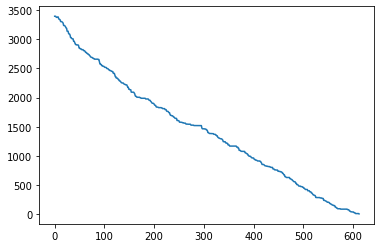

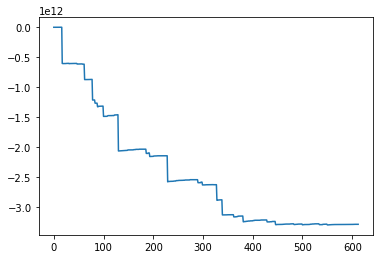

307.317914932


In [35]:
plt.plot(remaining_history)
plt.show()
plt.plot(revenue_history)
plt.show()
print(toc-tic)

In [36]:
new_port_item

,Bobot,Jarak,Pelabuhan,Tujuan Pelabuhan


In [37]:
chooseport('Banda Neira').demand

,Bobot,Jarak,Pelabuhan,Tujuan Pelabuhan


In [39]:
gl.loc[~gl.index.duplicated(keep='first')]

,Bobot,Jarak,Pelabuhan,Tujuan Pelabuhan


In [40]:
gl.index.duplicated(keep='first')

array([], dtype=bool)

In [41]:
a = pd.DataFrame(data={'a':['a','b',np.nan]})

In [42]:
a['a'] = a['a'].fillna(0)
a

,a
0,a
1,b
2,0


In [43]:
TL1.storage

,Bobot,Jarak,Pelabuhan,Tujuan Pelabuhan
